# Sampling Bias in IML for Bayesian Optimization  

The purpose of this notebook is to find out more about the effect of the sampling bias, and, if present, quantify the sampling bias. 

### Questions to be Answered

* How is the performance / uncertainty of the model in different regions (regions of points that are in the opt path, as well as in general)? 

* In what sense do the following options produce different results? 

| | Method | Data | Model | Comment |
| :---: | :---: | :---: | :---: | :---: |
| 1 | PDP | LHS Data | Ground-truth objective | Ground-truth 1, no model and no sampling bias |
| 2 | PDP | OptPath Data | Ground-truth objective | Ground-truth 2, no model but sampling bias |
| 3 | PDP | LHS Data | Surrogate on LHS | Empirical version of #1, (slight) model and no sampling bias |
| 4 | PDP | OptPath Data | Surrogate on LHS | Empirical version of #2, (slight) model and no sampling bias |
| 3 | PDP | LHS Data | Surrogate on MBO data | Empirical version of #1, (heavy) model bias, no sampling bias |
| 4 | PDP | OptPath Data | Surrogate on LHS | Empirical version of #2, (heavy) model bias and sampling bias |


We will first have a look at the ground truth variants (1 and 2) and discuss which of the two concepts is more appropriate. 

We consider two scenarios in which we have a ground-truth: 
* Scenario 1: Synthetic 2D test function
* Scenario 2: LBench surrogate meta-model (as an approximation to the true objective function). This surrogate meta-model can be assumed as the ground-truth objective function in this case. 

In [36]:
# test function
library("smoof")
library("ParamHelpers")

# data handling
library("data.table")
library(BBmisc)

# visualization
library("plot3D")
library("ggplot2")
library("GGally")
library("gridExtra")
library("rpart.plot")
library("rattle")
library("RColorBrewer")

# mlrMBO
library("mlrMBO")
library("mlr")

# iml methods
library("iml")

options(repr.plot.width=10, repr.plot.height=10)
theme_set(theme_bw())


Attaching package: ‘BBmisc’


The following object is masked from ‘package:base’:

    isFALSE




## Scenario 1 - Optimizing a Synthetic Test Function via mlrMBO

We optimize the 3D StyblinkskiTang function. 

In [2]:
obj1 = makeSingleObjectiveFunction(name = "StyblinkskiTang3D", fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 5))
)

In [33]:
data = data.frame(x1 = c(1, 2, 3), x2 = c(3, 2, 1))
data
apply(data, 1, obj1)

x1,x2
<dbl>,<dbl>
1,3
2,2
3,1


[1] -29 -38 -29

In [3]:
obj2 = makeSingleObjectiveFunction(name = "Rastrigin", fn = function(x) {
        20 + sum(x^2 - 10 * cos(2 * pi * x))
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 3))
)

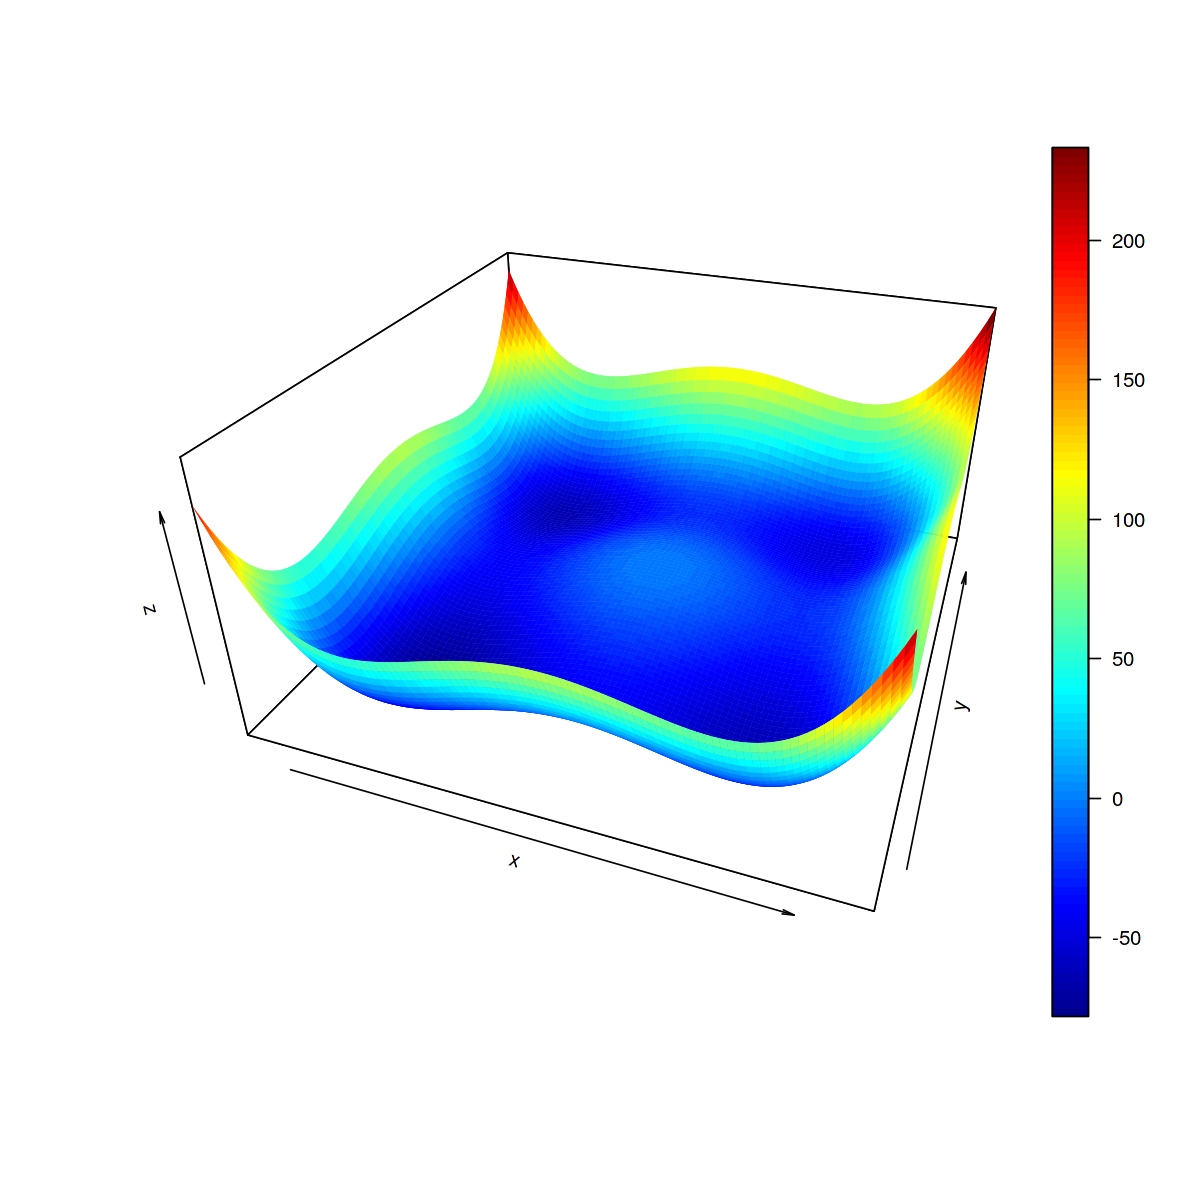

In [4]:
ps = getParamSet(obj1)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj1))
          
persp3D(x1, x2, y, theta = 20, phi = 30, expand = 0.5, border = NA)

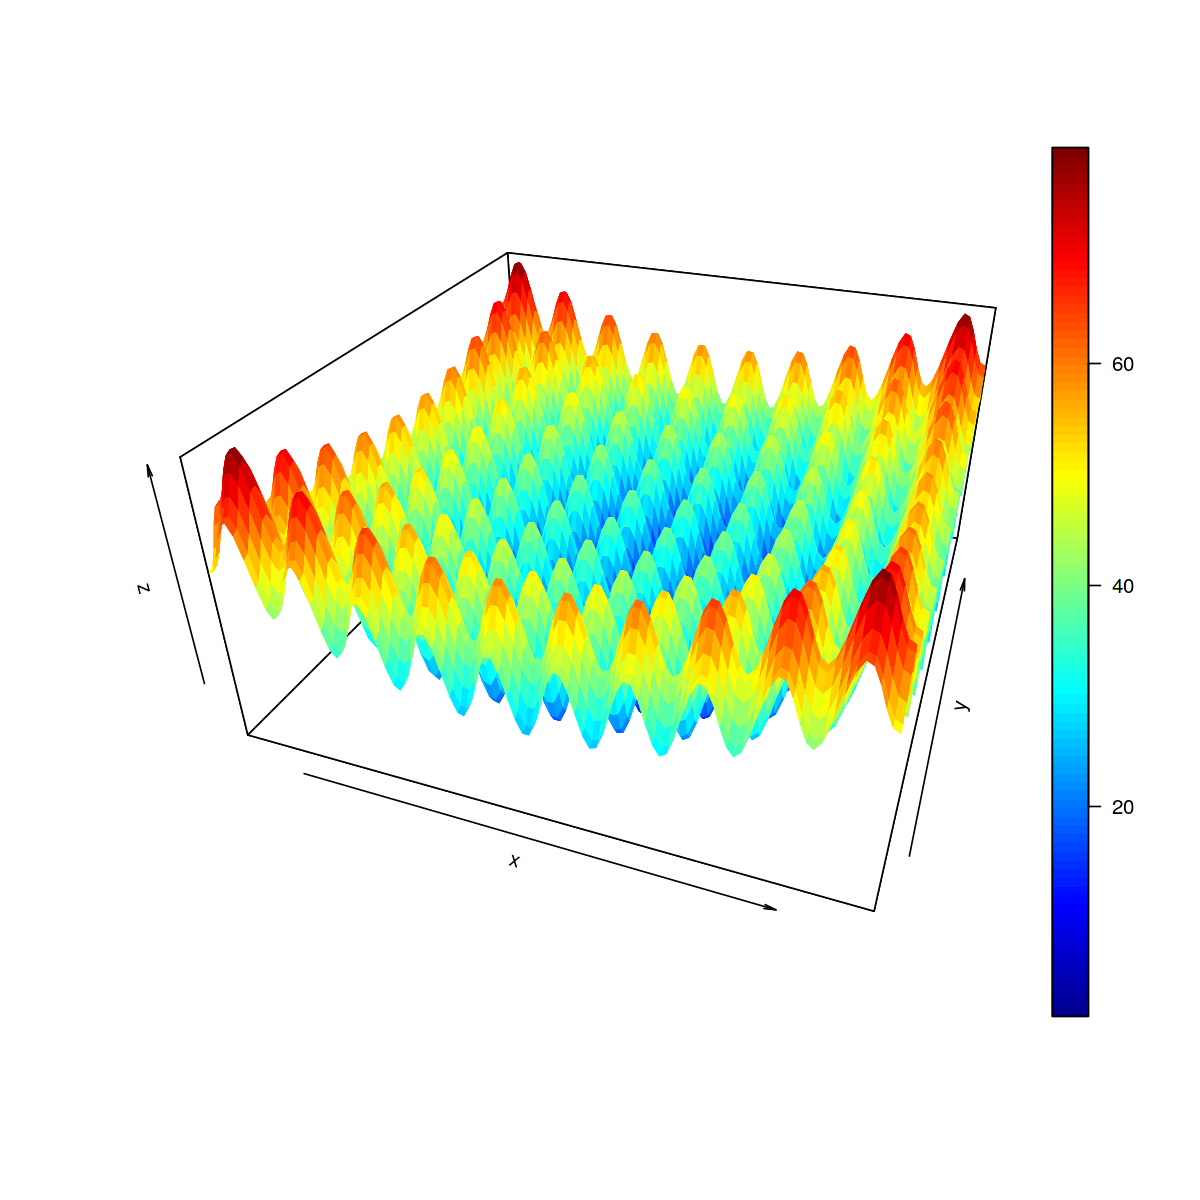

In [6]:
ps = getParamSet(obj2)

x11 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x22 <- x11
y2 = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj2))
          
persp3D(x11, x22, y2, theta = 20, phi = 30, expand = 0.5, border = NA)

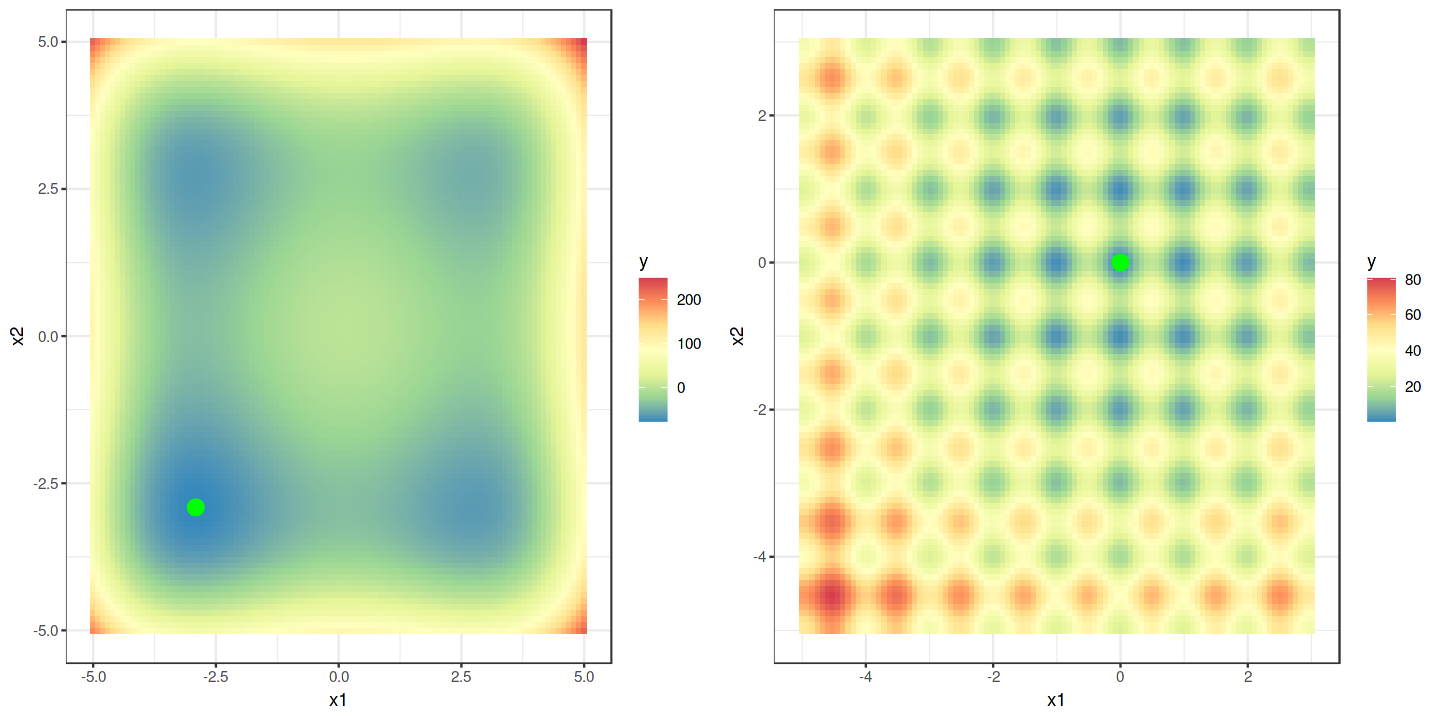

In [7]:
options(repr.plot.width=12, repr.plot.height=6)

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj1)

gg2 <- expand.grid(x1 = x11, x2 = x22)
gg2$y = apply(gg2, 1, obj2)


p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

p_obj_2 = ggplot() + geom_tile(data = gg2, aes(x = x1, y = x2, fill = y))
p_obj_2 = p_obj_2 + scale_fill_distiller(palette = "Spectral")
p_obj_2 = p_obj_2 + geom_point(data = data.frame(x = 0, y = 0), aes(x = x, y = y), colour = "green", size = 4)

grid.arrange(p_obj_1, p_obj_2, ncol = 2)

### Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

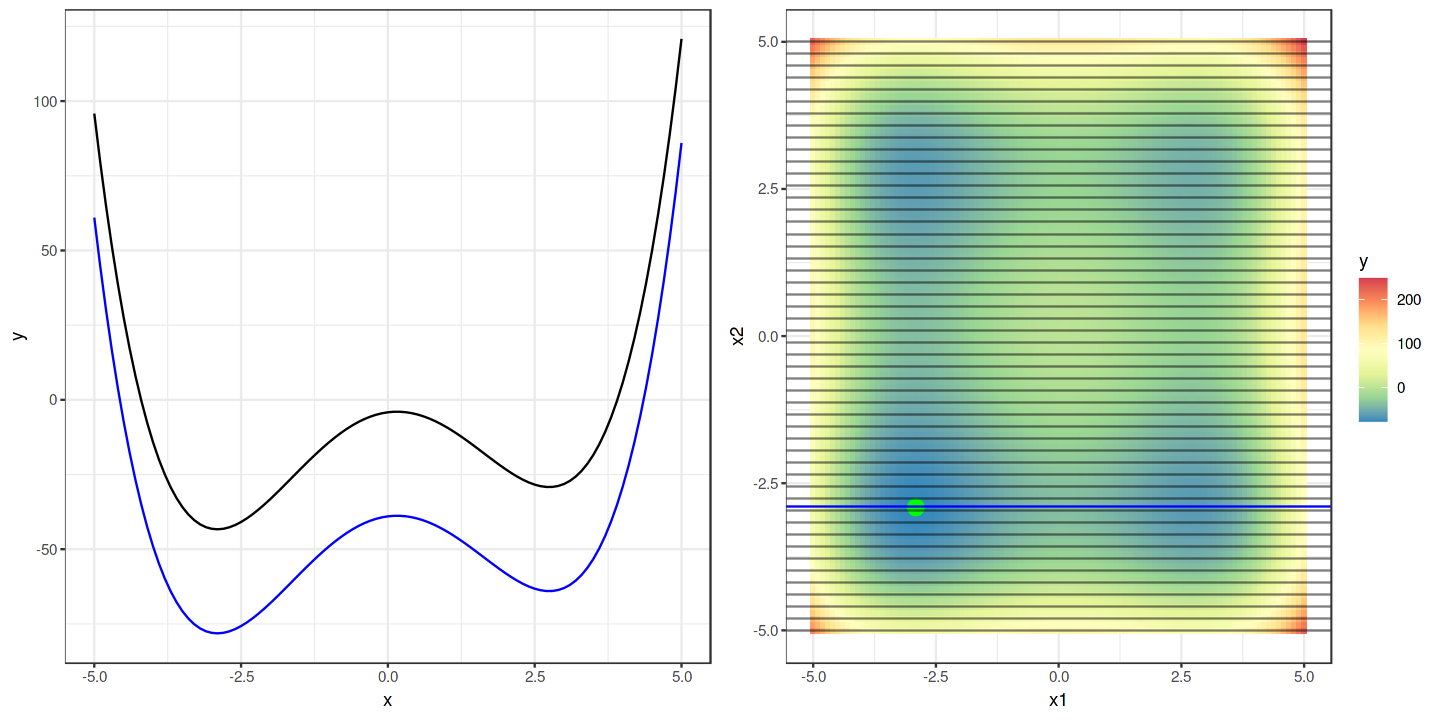

In [8]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

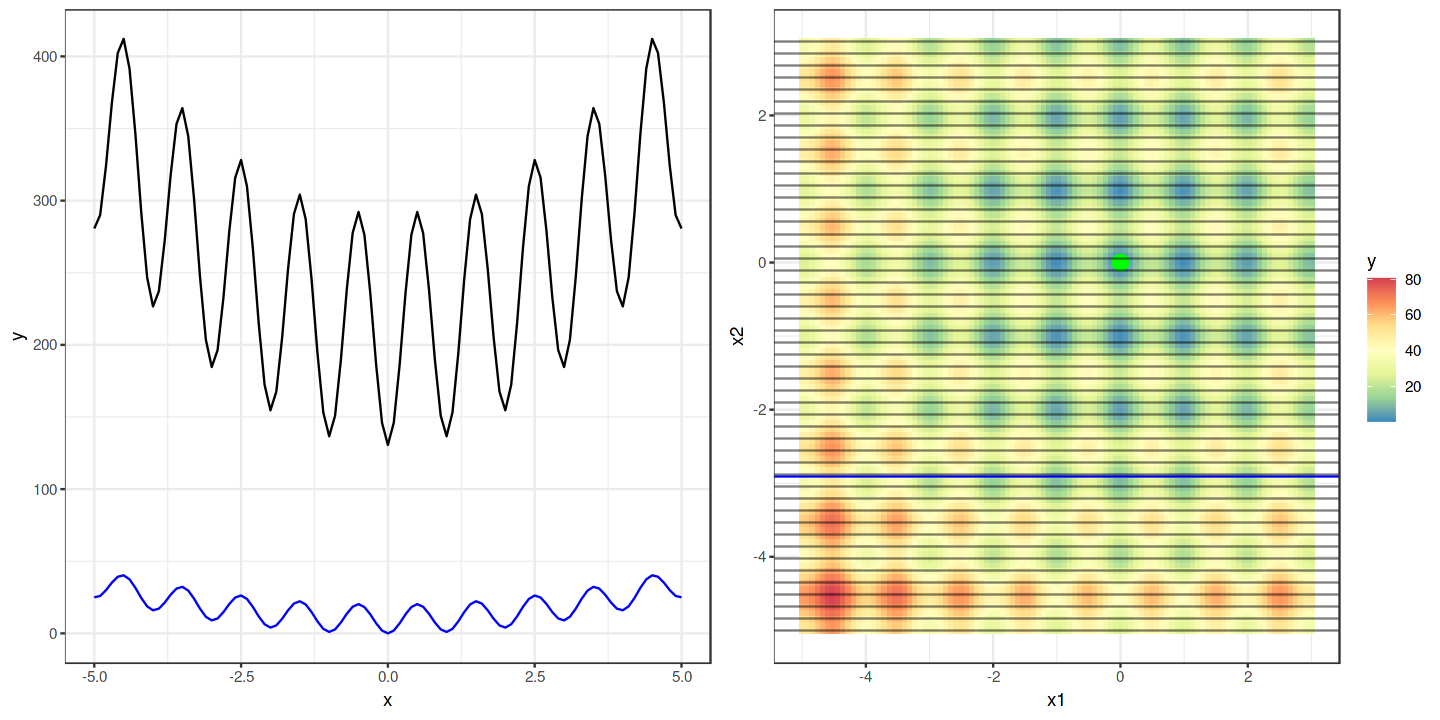

In [9]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 3)), aes(x = x), fun = function(x) 6 * x^2 - 80 * cos(2 * pi * x) + 632 / 3)
lines = seq(-5, 3, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 20 + x^2 - 10 * cos(2 * pi * x) - 10, colour = "blue")
p2 = p_obj_2 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Considering MBO Runs

Next, we create `mlrMBO` runs as well as a model fitted on the randomLHS data. 

In [10]:
createMBOrun = function(fun, max.evals, lambda, store_path, init_size = NULL) {
    
    ps = getParamSet(fun)

    ctrl = makeMBOControl(store.model.at = seq_len(max.evals))
    ctrl = setMBOControlTermination(ctrl, max.evals = max.evals)
    ctrl = setMBOControlInfill(ctrl, makeMBOInfillCritCB(cb.lambda = lambda))

    if (is.null(init_size))
        init_size = 4 * getParamLengths(ps)
        
    des = generateDesign(n = init_size, par.set = ps, fun = lhs::randomLHS)
    
    res = mbo(obj, design = des, control = ctrl, show.info = TRUE)
    
    saveRDS(res, store_path)
}

In [733]:
createMBOrun(fun = obj, max.evals = 50, lambda = 0.1, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=4.11,4.35 : y = 56.1 : 0.0 secs : initdesign

[mbo] 0: x=-1.58,-3.48 : y = -53 : 0.0 secs : initdesign

[mbo] 0: x=-4.92,-0.27 : y = 86 : 0.0 secs : initdesign

[mbo] 0: x=2.57,2.94 : y = -49 : 0.0 secs : initdesign

[mbo] 0: x=1.98,-1.9 : y = -45.8 : 0.0 secs : initdesign

[mbo] 0: x=-0.719,-5 : y = 93.8 : 0.0 secs : initdesign

[mbo] 0: x=-2.62,2.46 : y = -61.9 : 0.0 secs : initdesign

[mbo] 0: x=0.839,0.667 : y = -5.07 : 0.0 secs : initdesign

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 1: x=-1.04,2.57 : y = -35.3 : 0.0 secs : infill_cb

[mbo] 2: x=-4.02,2.39 : y = -31.9 : 0.0 secs : infill_cb

[mbo] 3: x=-2.43,2.46 : y = -59.8 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 4: 

In [734]:
createMBOrun(fun = obj, max.evals = 50, lambda = 1, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=-0.996,4.38 : y = 31.8 : 0.0 secs : initdesign

[mbo] 0: x=-1.86,0.22 : y = -26.1 : 0.0 secs : initdesign

[mbo] 0: x=2.19,-1.57 : y = -41.9 : 0.0 secs : initdesign

[mbo] 0: x=2.55,-4.43 : y = 0.191 : 0.0 secs : initdesign

[mbo] 0: x=-3.97,-3.57 : y = -41.8 : 0.0 secs : initdesign

[mbo] 0: x=4.29,1.36 : y = 22.7 : 0.0 secs : initdesign

[mbo] 0: x=0.996,-0.983 : y = -14.7 : 0.0 secs : initdesign

[mbo] 0: x=-3.1,3.67 : y = -46.3 : 0.0 secs : initdesign

[mbo] 1: x=4.34,-1.89 : y = 10.4 : 0.0 secs : infill_cb

[mbo] 2: x=-3.19,1.94 : y = -55.8 : 0.0 secs : infill_cb

[mbo] 3: x=-3.38,-0.0856 : y = -34.9 : 0.0 secs : infill_cb

[mbo] 4: x=-3.18,-4.68 : y = 15.6 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 5: x=-1.28,1.99 : y = -33.9 : 0.0 secs : infill_cb

[mbo] 6: x=-4.36,1.9 : y = -0.0174

In [735]:
createMBOrun(fun = obj, max.evals = 50, lambda = 10, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds")

Computing y column(s) for design. Not provided.

[mbo] 0: x=1.1,-4.6 : y = 37.4 : 0.0 secs : initdesign

[mbo] 0: x=2.6,5 : y = 100 : 0.0 secs : initdesign

[mbo] 0: x=4.52,1.33 : y = 47.2 : 0.0 secs : initdesign

[mbo] 0: x=1.47,-2.47 : y = -47.6 : 0.0 secs : initdesign

[mbo] 0: x=-3.6,-3.75 : y = -51.8 : 0.0 secs : initdesign

[mbo] 0: x=-0.596,2.64 : y = -29.1 : 0.0 secs : initdesign

[mbo] 0: x=-4.05,0.484 : y = -7.58 : 0.0 secs : initdesign

[mbo] 0: x=-1.94,-0.295 : y = -29.3 : 0.0 secs : initdesign

[mbo] 1: x=2.1,-4.21 : y = -15.6 : 0.0 secs : infill_cb

[mbo] 2: x=-3.4,-1.35 : y = -50.4 : 0.0 secs : infill_cb

[mbo] 3: x=-3,5 : y = 86 : 0.0 secs : infill_cb

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 4: x=5,-1.15 : y = 112 : 0.0 secs : infill_cb

[mbo] 5: x=-1.54,-5 : y = 80 : 0.0 secs : infill_cb

[mbo] 6: x=0.993,0.935 : y = -9.19 : 0.0 secs : infill_cb

[mbo]

In [803]:
createMBOrun(fun = obj, max.evals = 51, lambda = 11, store_path = "synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds", init_size = 50)

Computing y column(s) for design. Not provided.

[mbo] 0: x=3.9,-2.88 : y = -35.3 : 0.0 secs : initdesign

[mbo] 0: x=-2.41,-4.82 : y = 36 : 0.0 secs : initdesign

[mbo] 0: x=-0.813,-3.53 : y = -37.9 : 0.0 secs : initdesign

[mbo] 0: x=0.81,-0.411 : y = -5.38 : 0.0 secs : initdesign

[mbo] 0: x=1.31,-1.97 : y = -37.5 : 0.0 secs : initdesign

[mbo] 0: x=2.86,-1.13 : y = -37 : 0.0 secs : initdesign

[mbo] 0: x=-3.76,4.19 : y = 1.3 : 0.0 secs : initdesign

[mbo] 0: x=-3.11,1.61 : y = -51.8 : 0.0 secs : initdesign

[mbo] 0: x=-4.49,0.229 : y = 31.2 : 0.0 secs : initdesign

[mbo] 0: x=0.72,1.53 : y = -14.3 : 0.0 secs : initdesign

[mbo] 0: x=3.09,-4.79 : y = 44.6 : 0.0 secs : initdesign

[mbo] 0: x=-3.85,0.695 : y = -20.3 : 0.0 secs : initdesign

[mbo] 0: x=-3.55,4.67 : y = 45.2 : 0.0 secs : initdesign

[mbo] 0: x=4.53,-1.28 : y = 43.1 : 0.0 secs : initdesign

[mbo] 0: x=-1.16,-0.136 : y = -13.2 : 0.0 secs : initdesign

[mbo] 0: x=4.23,1.26 : y = 19.2 : 0.0 secs : initdesign

[mbo] 0: x=-2.

In [11]:
runs = list(# lambda01 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds"), 
            lambda1 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds"),
            # lambda10 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds"), 
            lhs = readRDS("synthetic//mlrmbo_run_StyblinkskiTang3D_lhs.rds"))

In [12]:
# concatenate the opt.paths
opdf = lapply(runs, function(x) {
    df = as.data.table(as.data.frame(x$opt.path))
    names(df)[ncol(df)] = "cb.lambda"
    df$cb.lambda.t = paste("lambda", df$cb.lambda[!is.na(df$cb.lambda)][1], sep = "")
    if (11 %in% df$cb.lambda)
        df$cb.lambda.t = "LHS"
    return(df)
    }
)

opdf = do.call(rbind, opdf)
opdf$cb.lambda.t = as.factor(opdf$cb.lambda.t)

models = lapply(seq_along(runs), function(i) {
    df = as.data.table(as.data.frame(runs[[i]]$opt.path))
    names(df)[ncol(df)] = "cb.lambda"
    models = runs[[i]]$models
    model = models[[length(models)]]
    if (11 %in% df$cb.lambda)
        model = models[[1]]
    return(model)
    })
names(models) = unique(opdf$cb.lambda.t)

In [13]:
summary(opdf)

       x1                x2                y                dob       
 Min.   :-4.8635   Min.   :-4.8176   Min.   :-78.332   Min.   : 0.00  
 1st Qu.:-2.9388   1st Qu.:-2.9059   1st Qu.:-77.862   1st Qu.: 0.00  
 Median :-2.7450   Median :-1.6480   Median :-37.946   Median : 0.00  
 Mean   :-1.1147   Mean   :-0.6549   Mean   :-28.538   Mean   : 8.95  
 3rd Qu.: 0.9958   3rd Qu.: 1.9391   3rd Qu.: -6.677   3rd Qu.:17.00  
 Max.   : 4.9992   Max.   : 4.9999   Max.   :249.854   Max.   :42.00  
                                                                      
      eol      error.message        exec.time               cb         
 Min.   : NA   Length:101         Min.   :0.000e+00   Min.   :-313.31  
 1st Qu.: NA   Class :character   1st Qu.:0.000e+00   1st Qu.: -78.39  
 Median : NA   Mode  :character   Median :0.000e+00   Median : -78.34  
 Mean   :NaN                      Mean   :4.951e-05   Mean   : -79.45  
 3rd Qu.: NA                      3rd Qu.:0.000e+00   3rd Qu.: -69.06  


In [14]:
head(models)

$lambda1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 50; features = 2
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$LHS
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 50; features = 2
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08


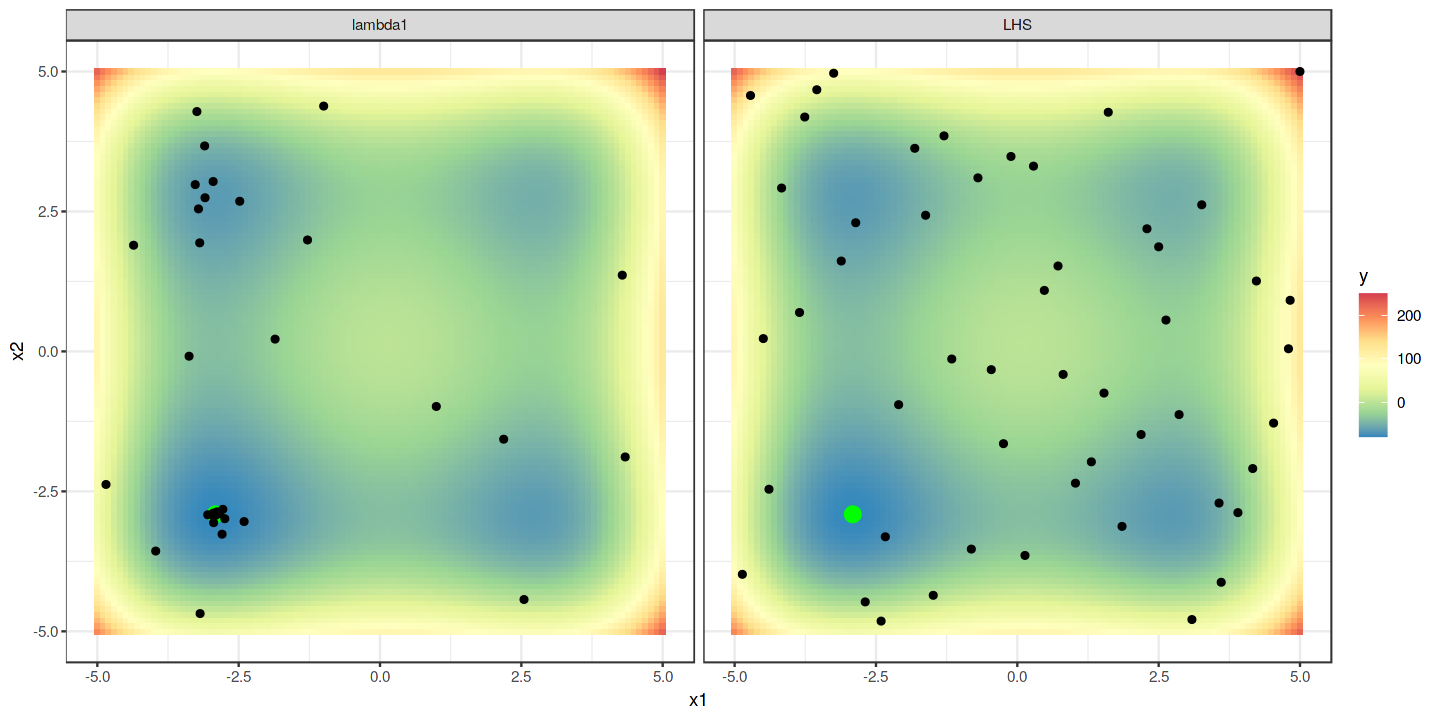

In [15]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = p_obj_1 + geom_point(data = opdf[cb.lambda.t %in% c("lambda1", "LHS"),], aes(x = x1, y = x2)) 
p1 = p1 + facet_grid(. ~ cb.lambda.t) 
p1

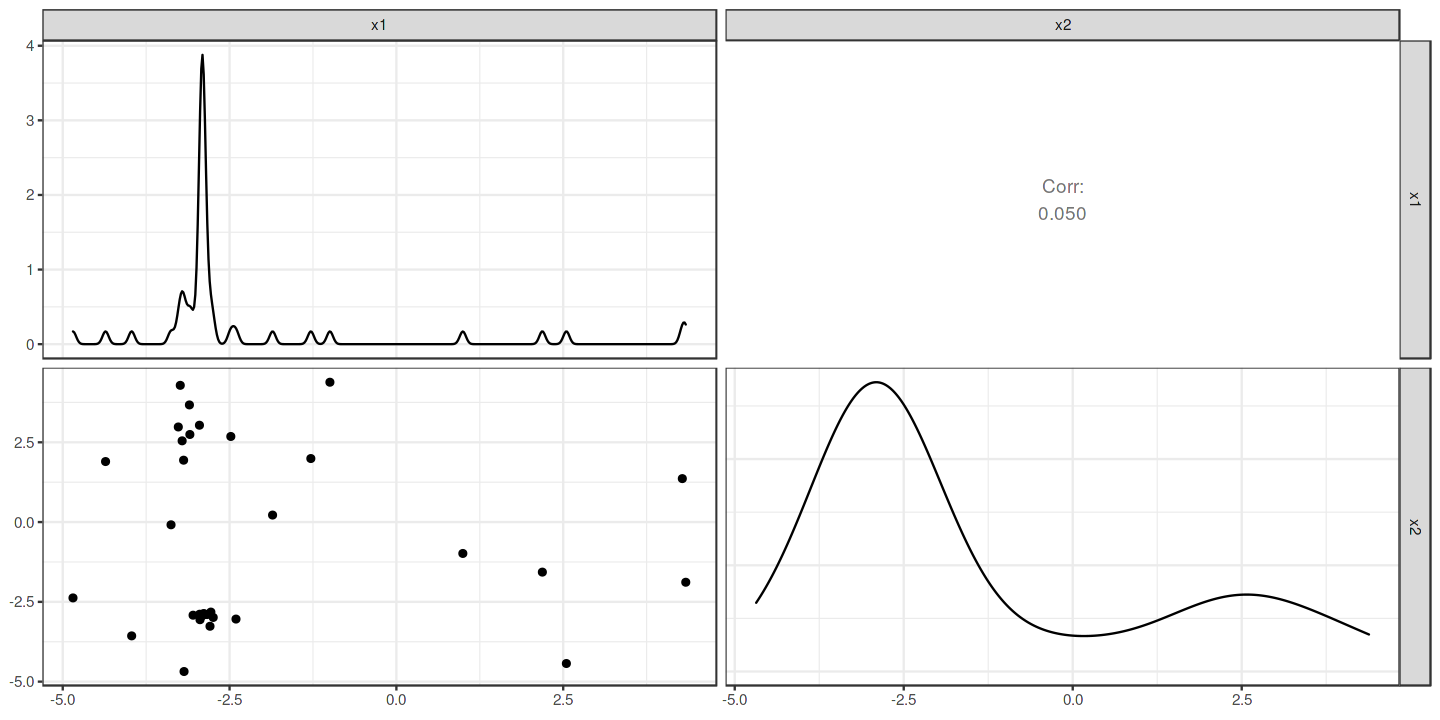

In [16]:
ggpairs(opdf[cb.lambda.t == "lambda1", c("x1", "x2")])

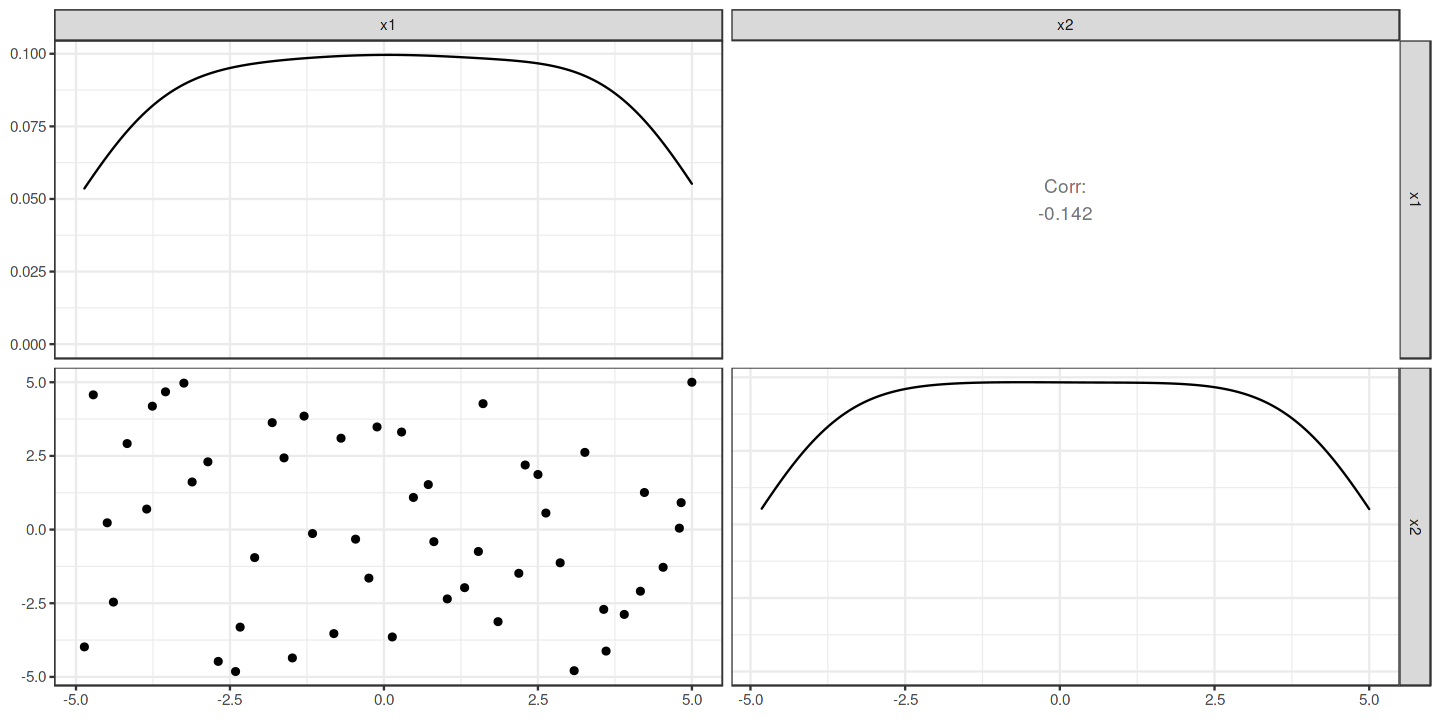

In [17]:
ggpairs(opdf[cb.lambda.t == "LHS", c("x1", "x2")])

Now, we investigate the fit. 

In [18]:
# We create a huge design 
x1 = seq(-5, 5, length.out = 50)

gg <- expand.grid(x1 = x1, x2 = x1)
gg$y = apply(gg, 1, obj1)

In [19]:
# mods = c("lambda0.1", "lambda1", "lambda10", "LHS")
mods = c("lambda1", "LHS")

preds = lapply(seq_along(models), function(i) {
    pred = predict(models[[i]], newdata = gg)$data
    pred$residual = pred$response - gg$y
    pred$abs_error = abs(pred$response - gg$y)
    pred$cb.lambda.t = mods[i]
    cbind(gg, pred)
    }
)

In [20]:
preds = do.call(rbind, preds)

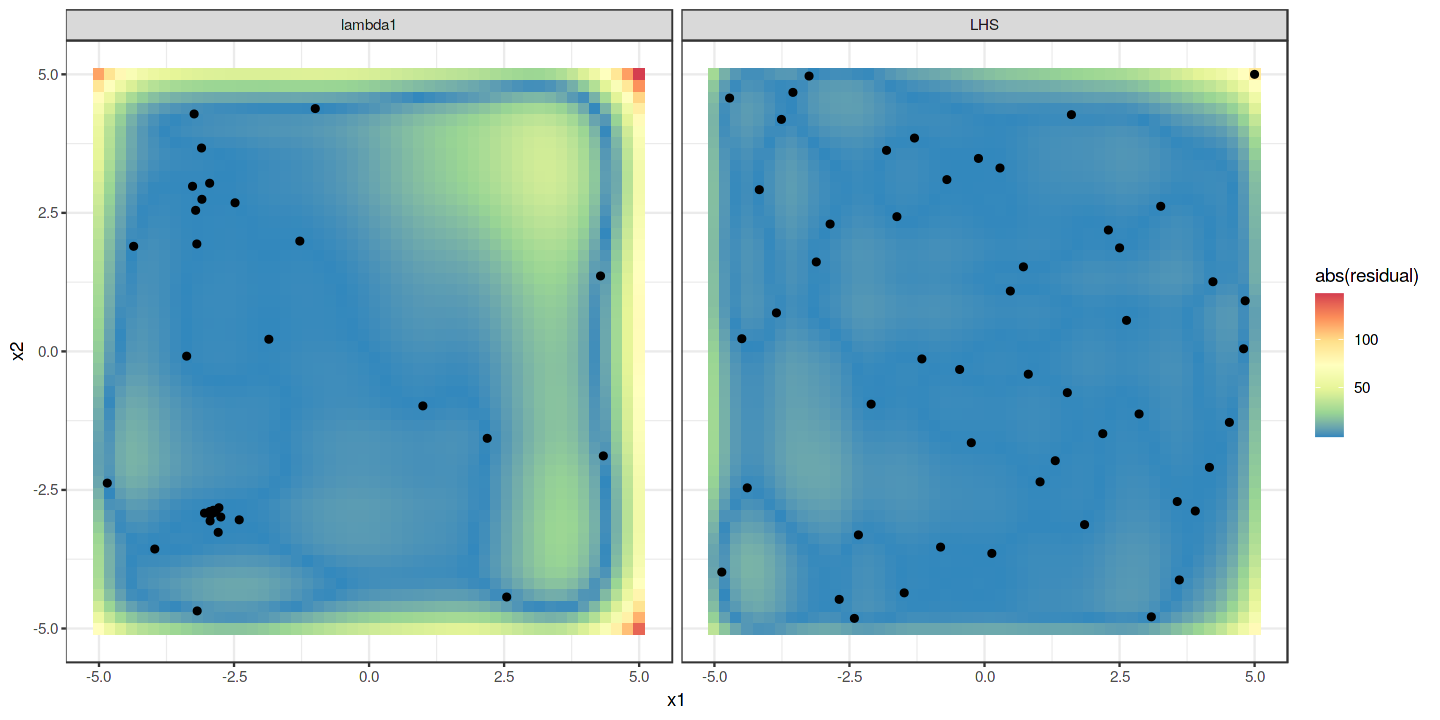

In [21]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

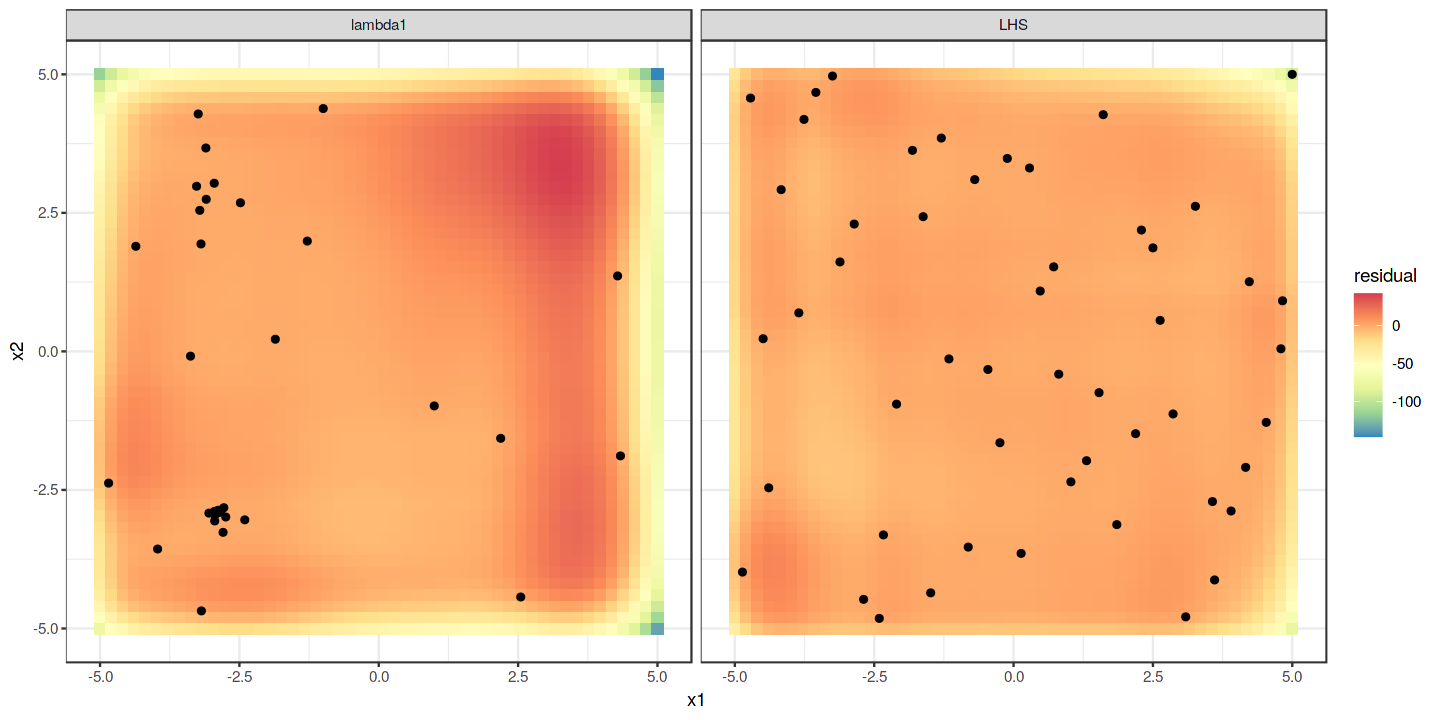

In [22]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

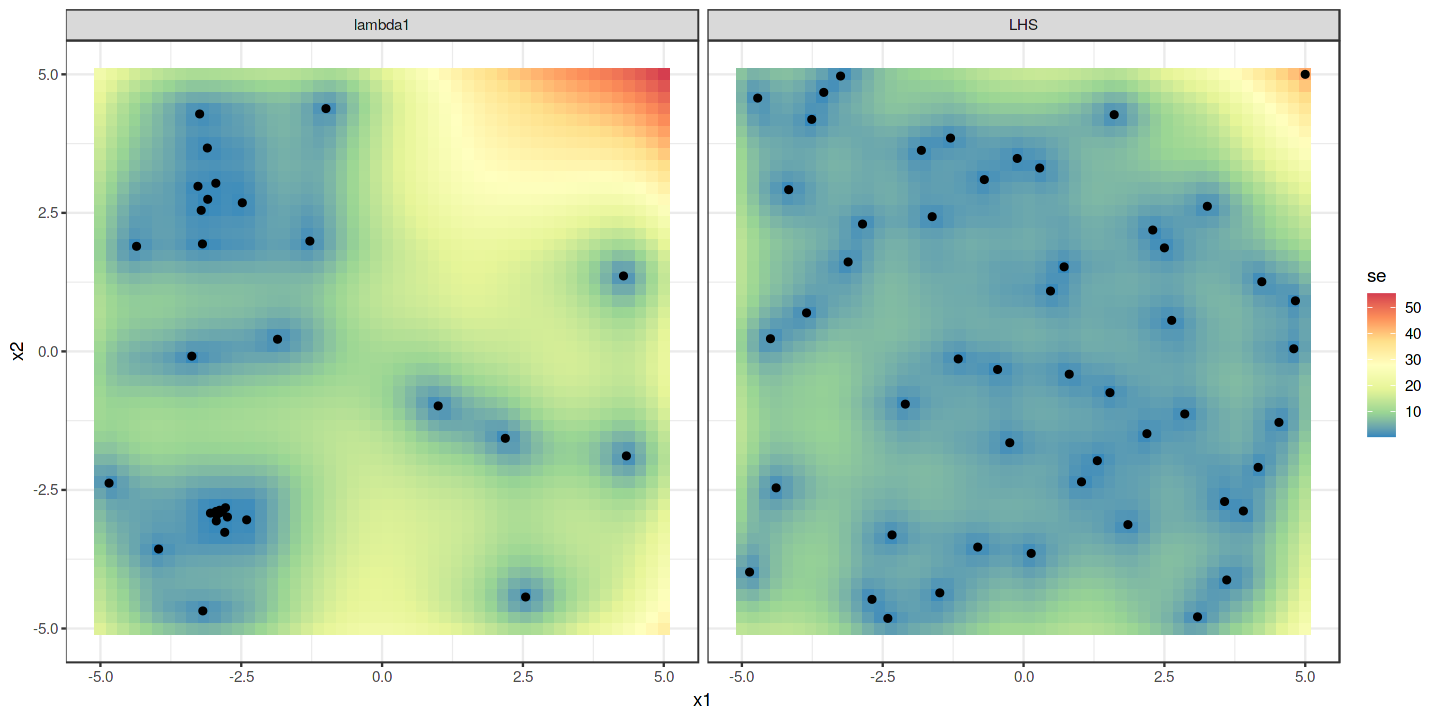

In [23]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ cb.lambda.t)

# High error means over-estimation 

Now, we investigate the PDPs (as a first start). 

In [44]:
gtPDP = function(obj, feature, testdata_runtype) {
    
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    
    mymodel = makeS3Obj("mymodel", fun = function(data) return(apply(data[, c("x1", "x2")], 1, obj1)))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
                        
    predictor = Predictor$new(model = mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
                    
    return(effects)
}

In [238]:
getPDPSE = function(runtype, feature, testdata_runtype, method = "pdp") {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])

    mod = models[[runtype]]
    mymodel = makeS3Obj("mymodel", fun = function() return(mod))
    
    predict.mymodel = function(object, newdata) {
      pred = predict(object$fun(), newdata = newdata)
      getPredictionSE(pred)
    }

    predictor = Predictor$new(mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = method)
    return(effects)
}

In [247]:
testdata_runtype = "LHS"
opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])

predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "ice")
eff = effects$results
names(eff)[1:2] = c("x", "y")

ice_data = getPDPSE("lambda1", "x1", "LHS", "ice")$results
names(ice_data)[1:2] = c("x", "se")

df = merge(eff, ice_data, by = c("x", ".type", ".id"))

In [248]:
se_max = max(df$se)
df$weight = (se_max - df$se) / se_max

In [249]:
df = setDT(df)
df$yweight = df$y * df$weight 

# df = df[, .(y = sum(yweight) / sum(weight)), by = "x"]

In [252]:
df

x,.type,.id,y,se,weight,yweight
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
-0.191668,ice,1,-46.559870,16.66067,0.7005441,-32.6172406
-0.191668,ice,10,-11.022916,12.18235,0.7810366,-8.6093010
-0.191668,ice,11,45.848416,20.64270,0.6289717,28.8373555
-0.191668,ice,12,-2.142669,12.82447,0.7694952,-1.6487734
-0.191668,ice,13,61.539473,12.14877,0.7816401,48.1017189
-0.191668,ice,14,-18.760169,12.46012,0.7760440,-14.5587169
-0.191668,ice,15,-2.080694,10.49597,0.8113472,-1.6881653
-0.191668,ice,16,-7.777708,12.90151,0.7681105,-5.9741393
-0.191668,ice,17,-18.937039,12.10734,0.7823848,-14.8160515


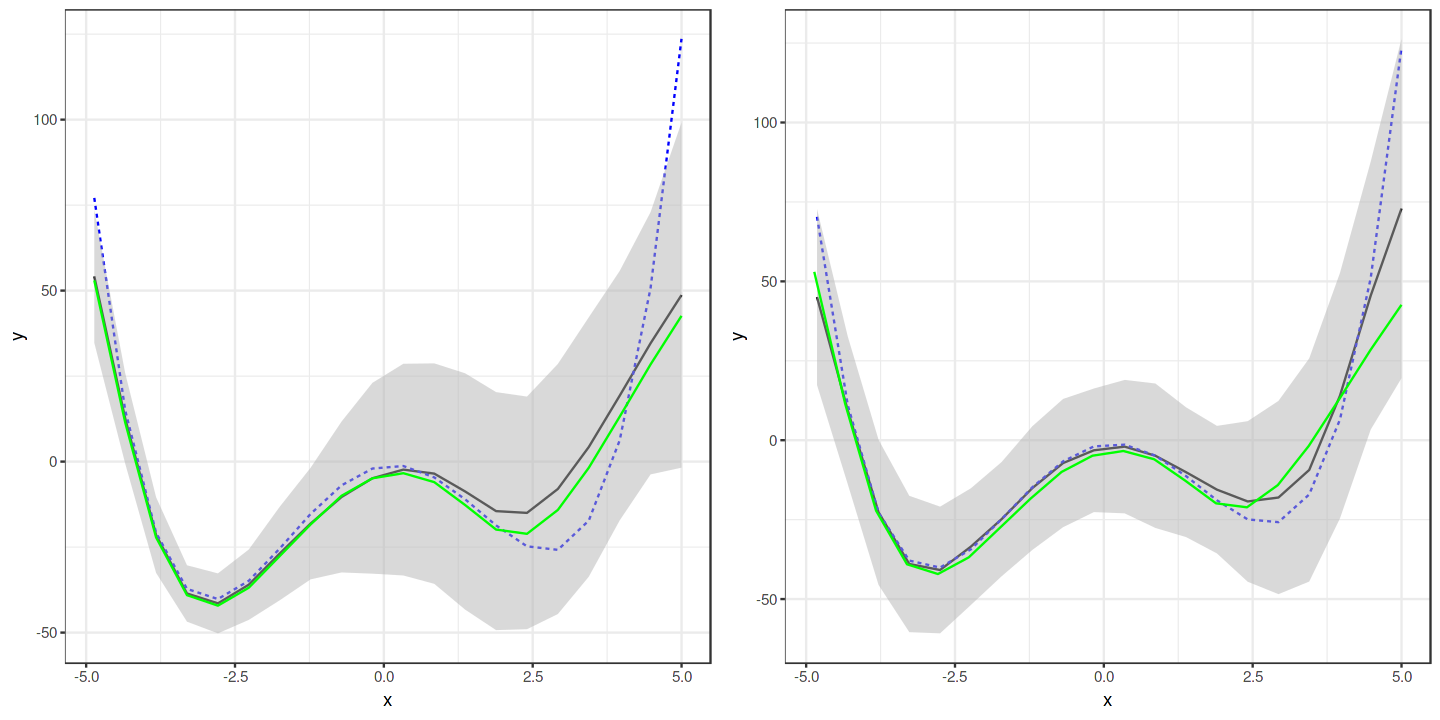

In [245]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE)
p1 = p1 + geom_line(data = df, aes(x = x, y = y), color = "green")

p2 = plotPDP(obj1, "lambda1", "x2", "LHS", gt = TRUE, se = TRUE)
p2 = p2 + geom_line(data = df, aes(x = x, y = y), color = "green")

grid.arrange(p1, p2, ncol = 2)

In [183]:
plotPDP = function(obj, runtype, feature, testdata_runtype, gt = FALSE, se = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])

    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
    eff = effects$results
    names(eff)[1:2] = c("x", "y")
    p = ggplot() + geom_line(data = eff, aes(x = x, y = y))
  
    if (gt) {
        df = gtPDP(obj, feature, testdata_runtype)$results
        names(df)[c(1, 2)] = c("x", "y")
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }

    if (se) {
        sd_data = getPDPSE(runtype, feature, testdata_runtype)$results
        df = cbind(eff, se = sd_data$.value)
        p = p + geom_ribbon(data = df, aes(x = x, ymin = y - 2 * se, ymax = y + 2 * se), fill = "grey70", alpha = 0.5)
    }    
    
    return(p)
}

In [26]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

In [27]:
plotALE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "ale", grid.size = 500L)
    p = effects$plot() + ggtitle(runtype) 
    if (gt) {
        df = gtPDP(obj, feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }
    return(p)
}

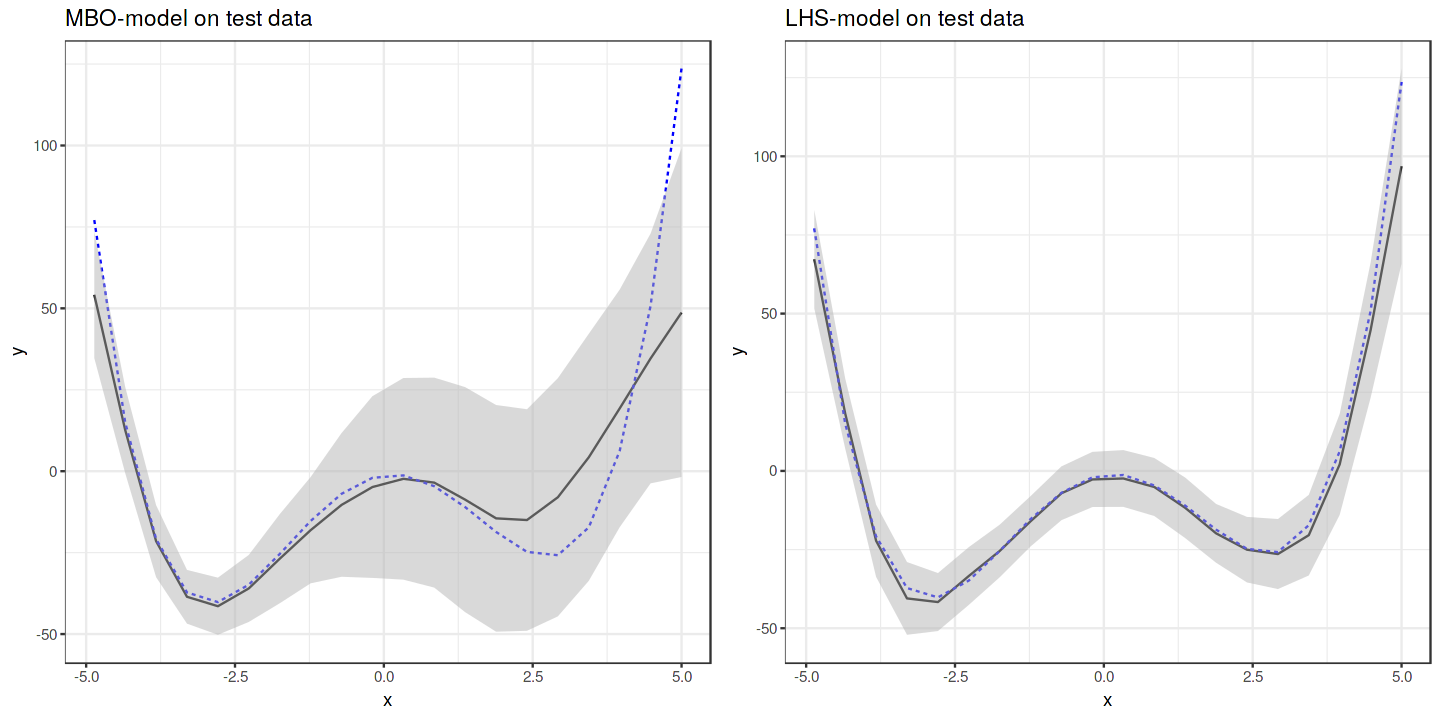

In [187]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

In [188]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

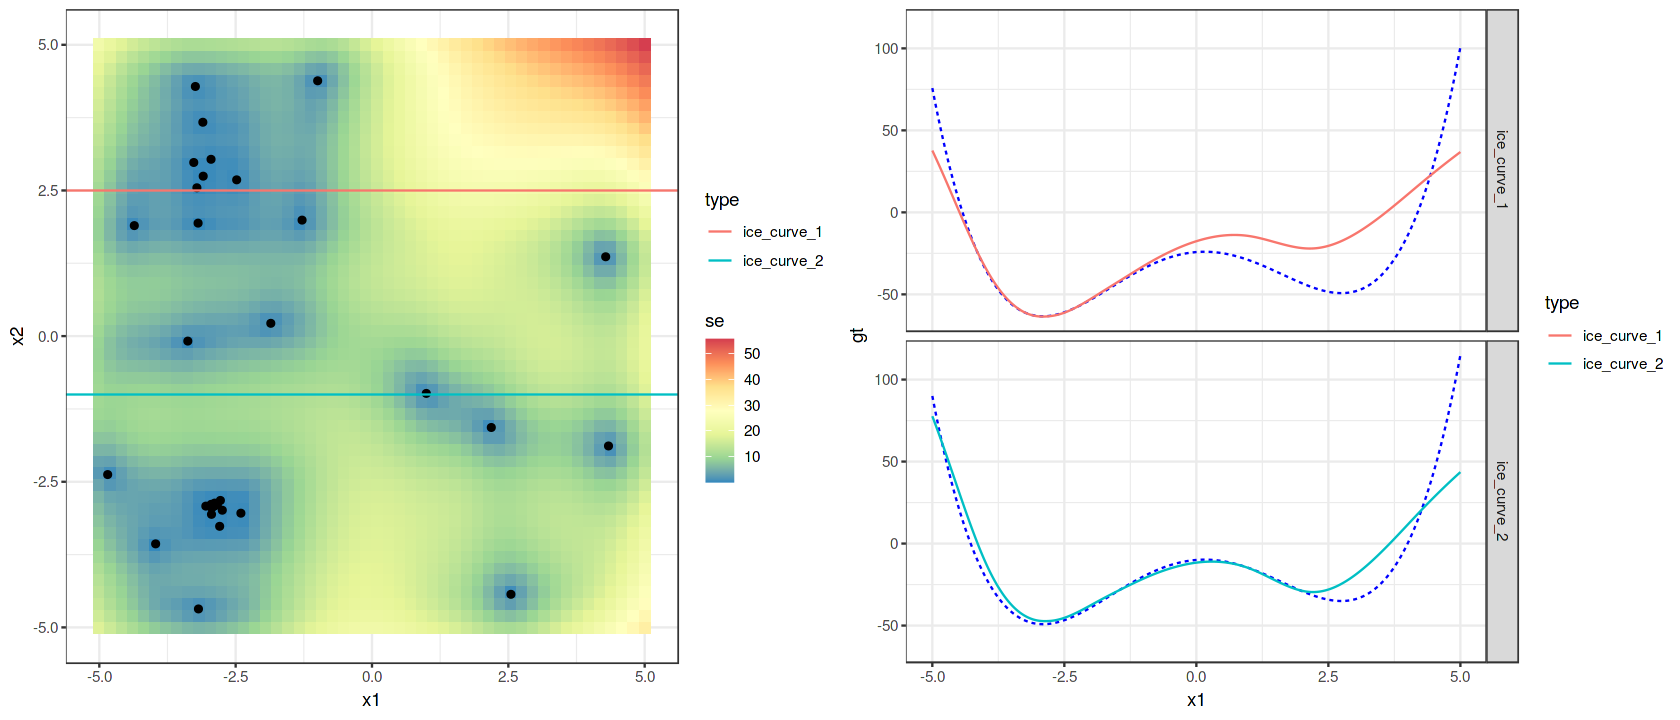

In [189]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

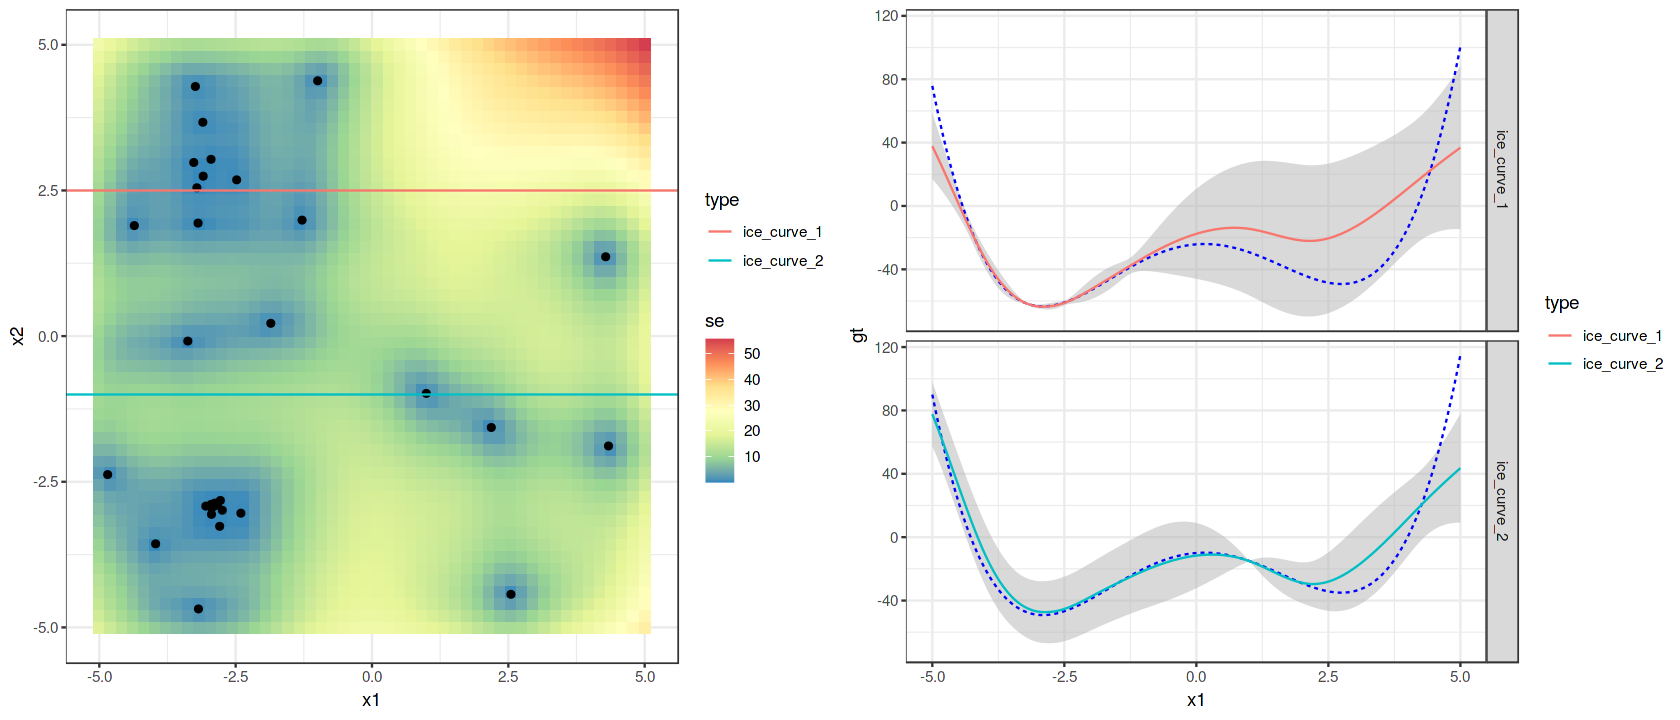

In [37]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

### Conditional Interpretations

In [190]:
# We now fit a tree to the se of the model to extract regions with low uncertainty

train_data_tree = generateDesign(n = 10000, par.set = ps, fun = lhs::randomLHS)

model_for_interpretation = "lambda1"
model = models[[model_for_interpretation]]

pred = predict(model, newdata = train_data_tree)

train_data_tree$response = pred$data$response
train_data_tree$se = pred$data$se

In [191]:
lrn_tree = makeLearner("regr.rpart", par.vals = list(maxdepth = 2))
task = makeRegrTask(data = train_data_tree[, c("x1", "x2", "se")], target = "se")
mod = train(lrn_tree, task)

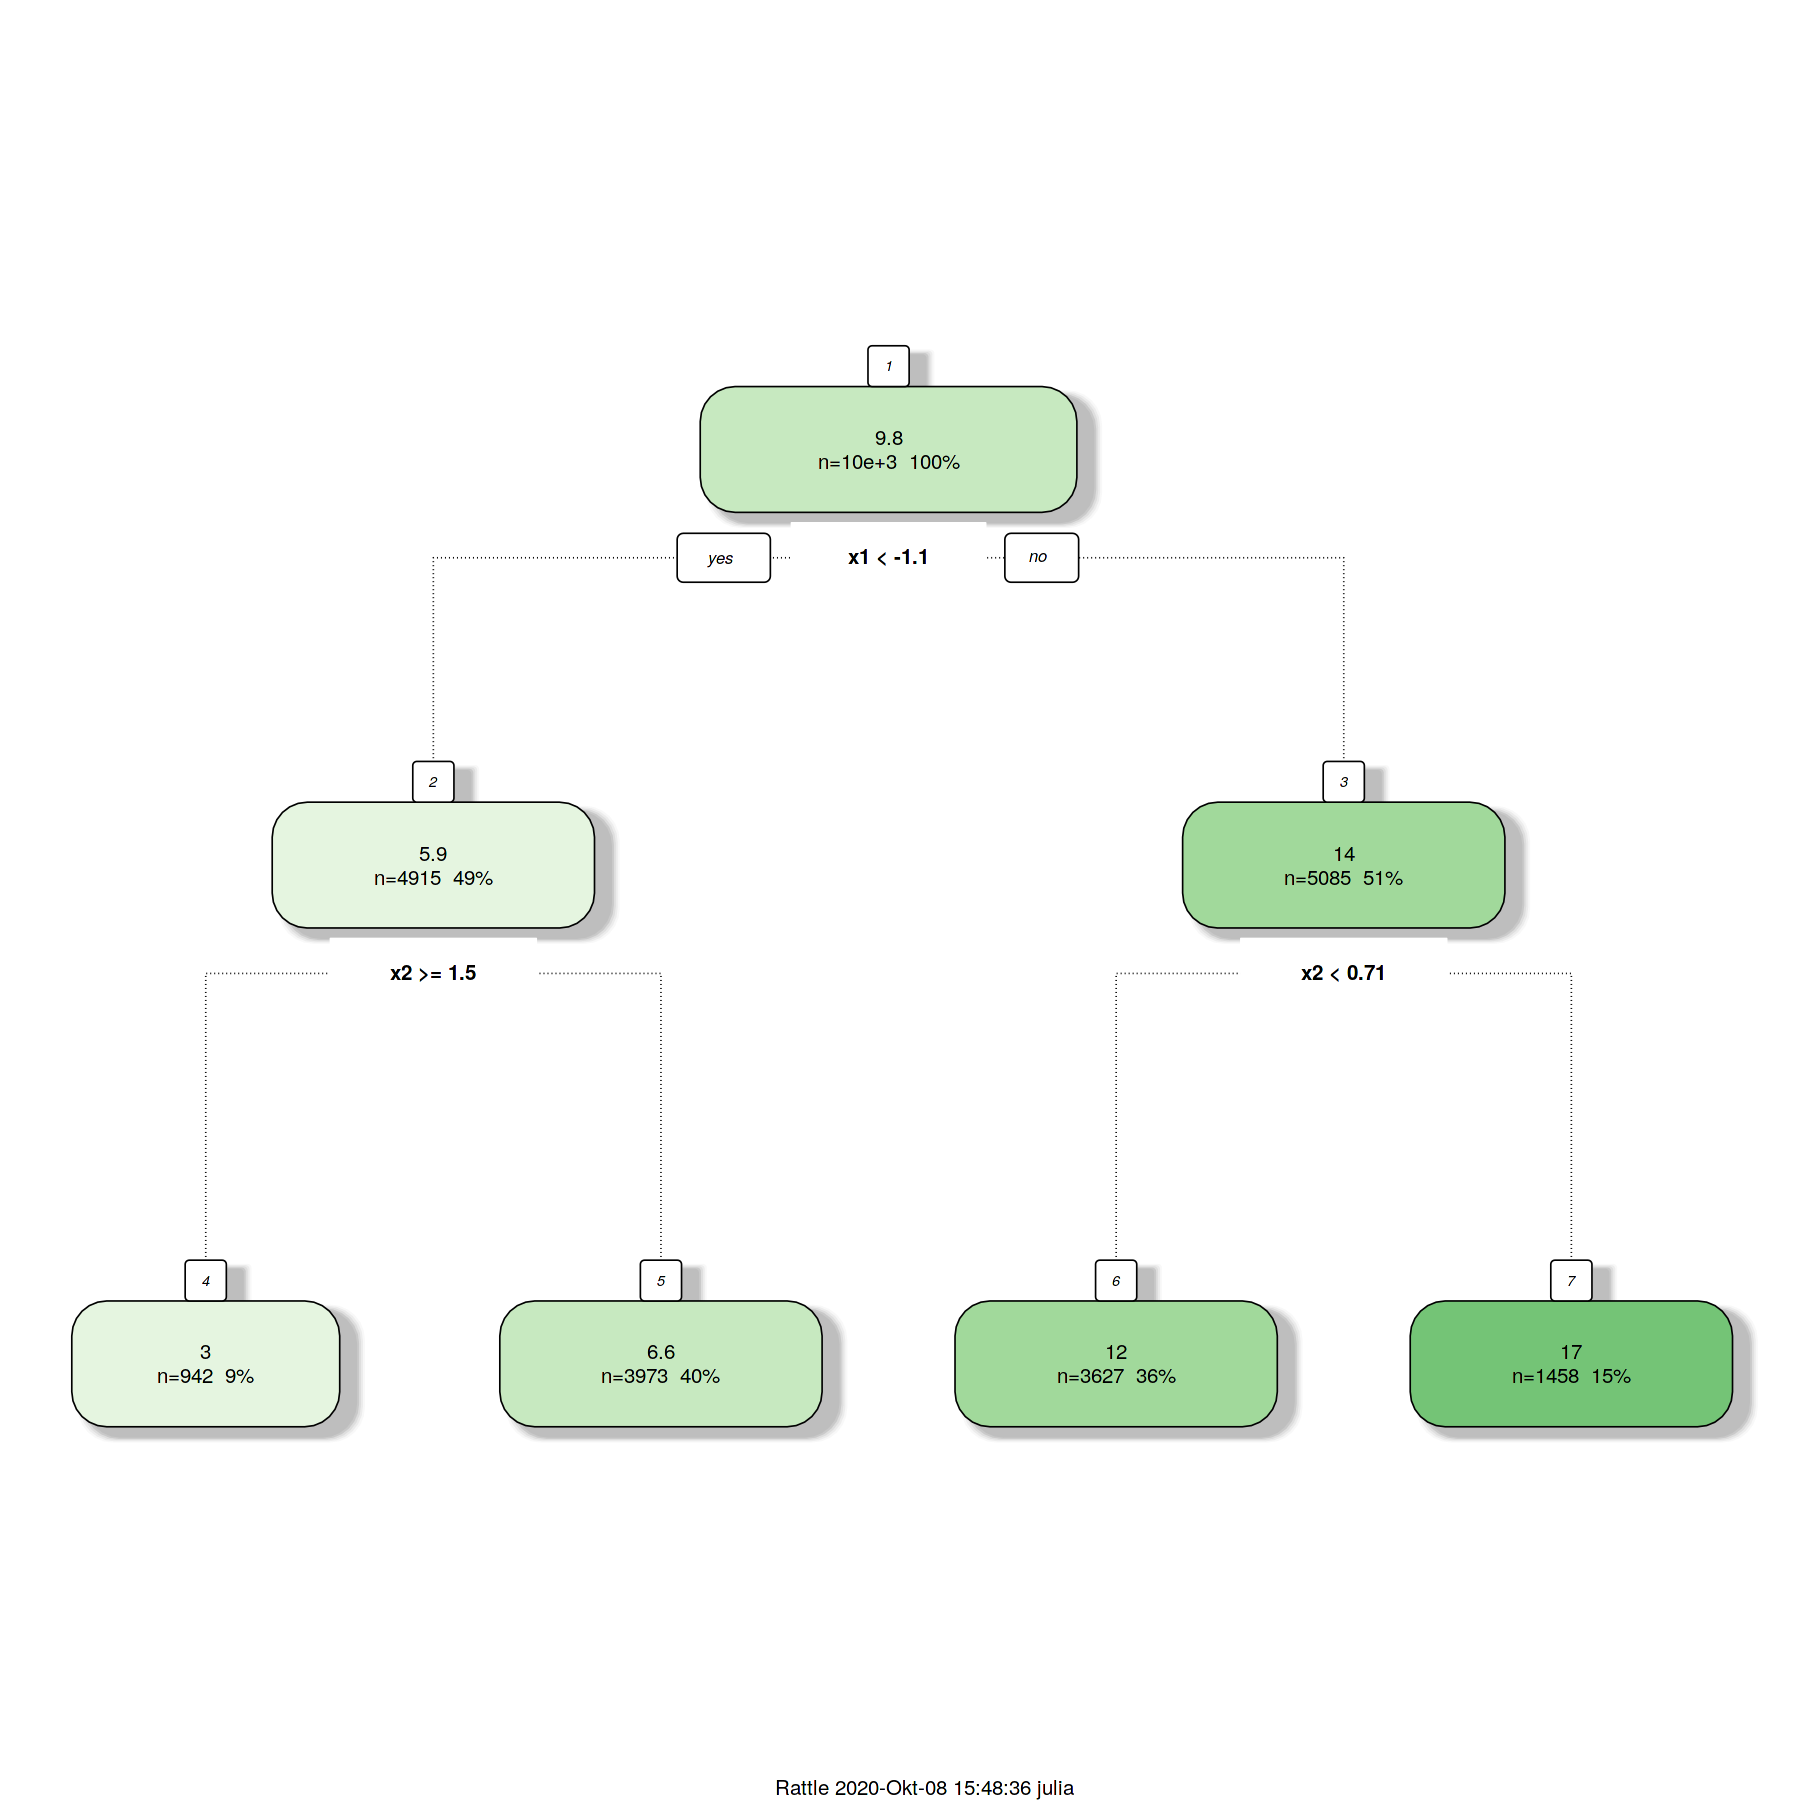

In [192]:
options(repr.plot.width = 15, repr.plot.height = 15)

fancyRpartPlot(mod$learner.model)

In [197]:
plotConditionalPDP = function(par_set, feature, runtype) {
    obj1_sub = makeSingleObjectiveFunction(name = "StyblinkskiTang3D", fn = function(x) {
            1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
        }, 
        par.set = par_set
    )  
    
    opdf_sub = generateDesign(n = 100, par.set = par_set, fun = lhs::randomLHS)
    predictor = Predictor$new(models[[runtype]], data = opdf_sub)
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")

    p11 = effects$plot() + ggtitle(runtype)

    df = gtPDP(obj = obj1, feature = feature, testdata_runtype = "LHS")
    p11 = p11 + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    return(p11)
}

In [198]:
ps11 = makeParamSet(
    makeNumericParam("x1", lower = -5, upper = -1.1),
    makeNumericParam("x2", lower = 1.6, upper = 5)
)

ps21 = makeParamSet(
    makeNumericParam("x1", lower = -5, upper = -1.1),
    makeNumericParam("x2", lower = -5, upper = 1.6)
)

ps12 = makeParamSet(
    makeNumericParam("x1", lower = -1.1, upper = 5),
    makeNumericParam("x2", lower = 1.6, upper = 5)
)

ps22 = makeParamSet(
    makeNumericParam("x1", lower = -1.1, upper = 5),
    makeNumericParam("x2", lower = -5, upper = 1.6)
)

p11 = plotConditionalPDP(ps11, "x1", "lambda1") + ggtitle("11") + ylim(c(-50, 50))
p21 = plotConditionalPDP(ps21, "x1", "lambda1") + ggtitle("21") + ylim(c(-50, 50))
p12 = plotConditionalPDP(ps12, "x1", "lambda1") + ggtitle("12") + ylim(c(-50, 50))
p22 = plotConditionalPDP(ps22, "x1", "lambda1") + ggtitle("22") + ylim(c(-50, 50))

ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not an S3 object with class FeatureEffect/InterpretationMethod/R6


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 50 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 36 row(s) containing missing values (geom_path).”
Warning message:
“Removed 38 row(s) containing missing values (geom_path).”


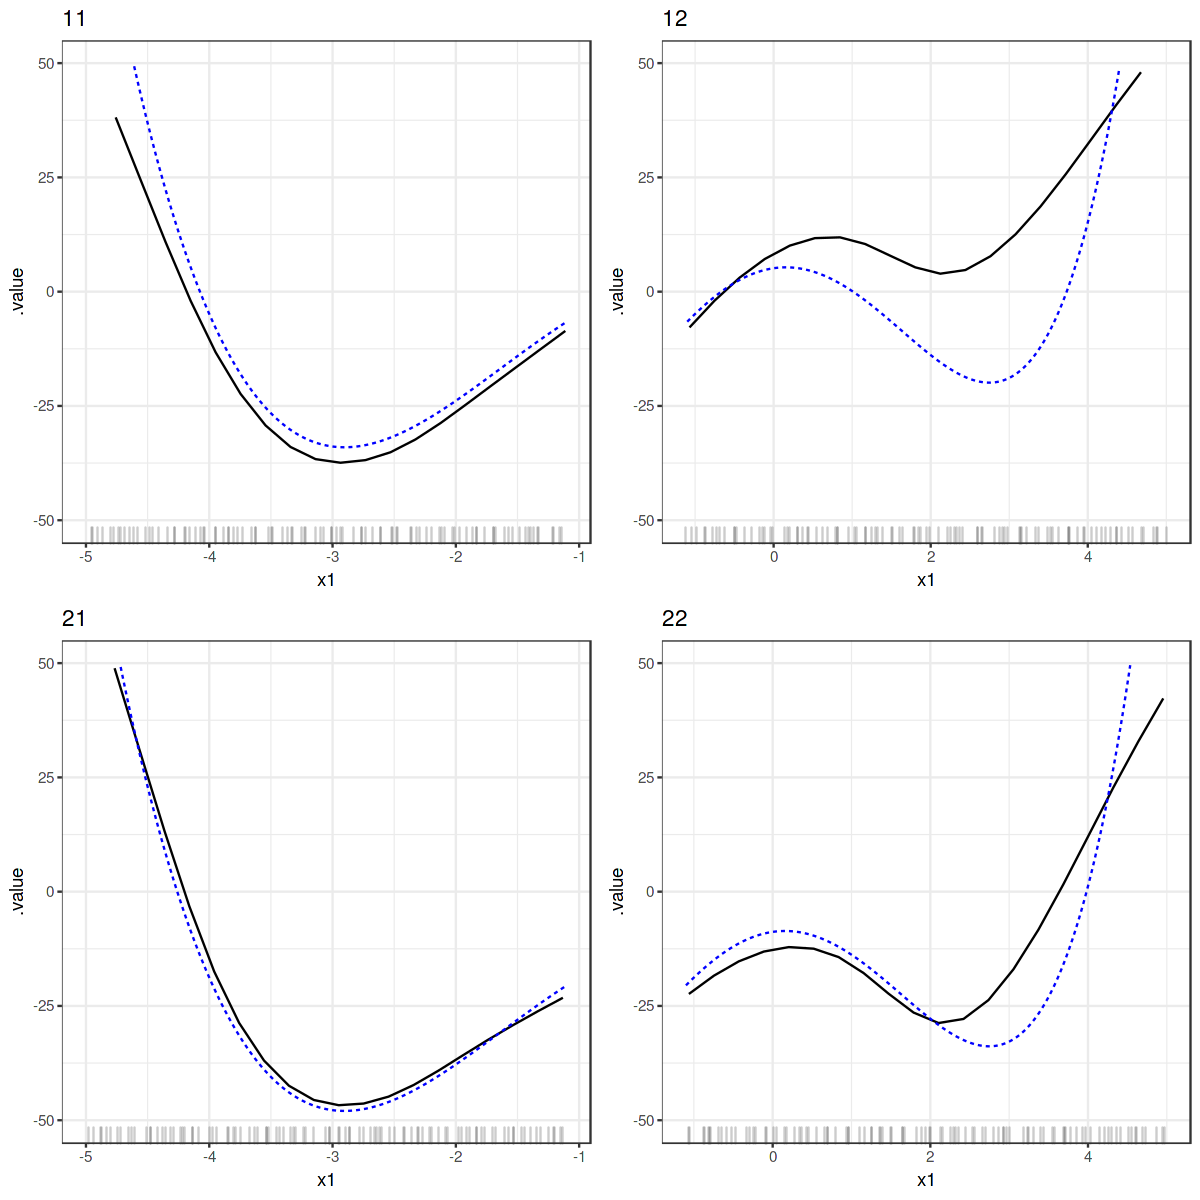

In [374]:
grid.arrange(p11, p12, p21, p22, ncol = 2)

### Mix with random evaluation

In [42]:
summary(opdf)

       x1                x2                y                dob       
 Min.   :-4.8635   Min.   :-4.8176   Min.   :-78.332   Min.   : 0.00  
 1st Qu.:-2.9388   1st Qu.:-2.9059   1st Qu.:-77.862   1st Qu.: 0.00  
 Median :-2.7450   Median :-1.6480   Median :-37.946   Median : 0.00  
 Mean   :-1.1147   Mean   :-0.6549   Mean   :-28.538   Mean   : 8.95  
 3rd Qu.: 0.9958   3rd Qu.: 1.9391   3rd Qu.: -6.677   3rd Qu.:17.00  
 Max.   : 4.9992   Max.   : 4.9999   Max.   :249.854   Max.   :42.00  
                                                                      
      eol      error.message        exec.time               cb         
 Min.   : NA   Length:101         Min.   :0.000e+00   Min.   :-313.31  
 1st Qu.: NA   Class :character   1st Qu.:0.000e+00   1st Qu.: -78.39  
 Median : NA   Mode  :character   Median :0.000e+00   Median : -78.34  
 Mean   :NaN                      Mean   :4.951e-05   Mean   : -79.45  
 3rd Qu.: NA                      3rd Qu.:0.000e+00   3rd Qu.: -69.06  


In [122]:
opdf_sub = opdf[cb.lambda.t == "lambda1", ]

In [119]:
# Generate a huge random design to extend
random_design = generateRandomDesign(2^10, par.set = ps)
random_design$y = apply(random_design, 1, obj1)
lhs_design = generateDesign(n = 2^10, par.set = ps, fun = lhs::randomLHS)
lhs_design$y = apply(lhs_design, 1, obj1)

In [61]:
lrn = runs$lambda1$final.opt.state$opt.problem$learner

In [66]:
models_random_design = lapply(seq_len(10), function(i) {
    ext_design = rbind(opdf_sub[, c("x1", "x2", "y")], random_design[seq_len(2^i), ])
    task = makeRegrTask(data = ext_design, target = "y")
    mod_update = train(learner = lrn, task = task)
    mod_update
})

Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in makeTask(type = type, data = data, weights = weights, blocki

In [123]:
models_lhs = lapply(seq_len(10), function(i) {
    ext_design = rbind(opdf_sub[, c("x1", "x2", "y")], lhs_design[seq_len(2^i), ])
    task = makeRegrTask(data = ext_design, target = "y")
    mod_update = train(learner = lrn, task = task)
    mod_update
})

Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class data.table, hence it will be converted.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not 

In [187]:
ctrl = makeMBOControl(store.model.at = 2^seq_len(8))
ctrl = setMBOControlTermination(ctrl, max.evals = nrow(opdf_sub) + 2^8)
ctrl = setMBOControlInfill(ctrl, crit.se)

In [188]:
additional_run = mbo(obj1, design = as.data.frame(opdf_sub[, c("x1", "x2", "y")]), control = ctrl, show.info = TRUE)

[mbo] 1: x=5,5 : y = 250 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 2: x=5,-5 : y = 225 : 0.0 secs : infill_se

[mbo] 3: x=2.51,5 : y = 101 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 4: x=-5,5 : y = 225 : 0.0 secs : infill_se

[mbo] 5: x=-0.137,-5 : y = 99.4 : 0.0 secs : infill_se

[mbo] 6: x=5,-0.219 : y = 124 : 0.0 secs : infill_se

[mbo] 7: x=1.38,3.27 : y = -30.3 : 0.0 secs : infill_se

[mbo] 8: x=3.53,3.68 : y = -20.6 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 9: x=5,-3.26 : y = 88.2 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size

[mbo] 57: x=-0.354,-3.18 : y = -39.6 : 0.0 secs : infill_se

[mbo] 58: x=4.07,-4.67 : y = 66.8 : 0.0 secs : infill_se

[mbo] 59: x=2.73,-1.01 : y = -35.2 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 60: x=4.64,-2.76 : y = 32.2 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 61: x=-2.15,-1.32 : y = -47.4 : 0.0 secs : infill_se

[mbo] 62: x=-3.63,-5 : y = 72.1 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 63: x=-4.3,4.65 : y = 84.6 : 0.0 secs : infill_se

[mbo] 64: x=-1.18,-2.45 : y = -49.2 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, m

[mbo] 131: x=-3.67,3.23 : y = -47.4 : 0.0 secs : infill_se

[mbo] 132: x=-0.48,-4.65 : y = 46 : 0.0 secs : infill_se

[mbo] 133: x=4.4,3.85 : y = 44.9 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 134: x=0.455,-2.5 : y = -37.3 : 0.0 secs : infill_se

[mbo] 135: x=1.1,1.25 : y = -14.3 : 0.0 secs : infill_se

[mbo] 136: x=4.88,-0.895 : y = 97.4 : 0.0 secs : infill_se

[mbo] 137: x=-1.57,-3.59 : y = -49.6 : 0.0 secs : infill_se

[mbo] 138: x=2.25,4.53 : y = 35.8 : 0.0 secs : infill_se

[mbo] 139: x=-0.848,2.88 : y = -32.4 : 0.0 secs : infill_se

[mbo] 140: x=-4.68,1.06 : y = 47.3 : 0.0 secs : infill_se

[mbo] 141: x=4.88,-1.65 : y = 82.6 : 0.0 secs : infill_se

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
[mbo] 142: x=5,1.58 : y = 112 : 0.0 secs : 

In [213]:
plotPDPSequence = function(obj, models, feature) {
    ps = getParamSet(obj)
    opdf_sub = generateDesign(n = 200, par.set = ps, fun = lhs::randomLHS)

    res = lapply(seq_along(models), function(i) {
        predictor = Predictor$new(models[[i]], data = opdf_sub[c("x1", "x2")])
        effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
        res = effects$results
        res$additional_evals = i
        res
    })
    res = do.call(rbind, res)
    p = ggplot()
    p = p + geom_line(data = res, aes(x = x1, y = .value, colour = additional_evals, group = additional_evals)) 
    
    df = gtPDP(obj = obj, var = feature)
    p = p + geom_line(data = df, aes(x = x, y = y), colour = "green", lty = 2)
    return(p)
}

In [214]:
p1 = plotPDPSequence(obj1, models_random_design, "x1")

In [215]:
p1 = p1 + ggtitle("PDPs with additional random evaluations") + ylim(c(-50, 20))

In [216]:
p2 = plotPDPSequence(obj1, models_lhs, "x1")

In [217]:
options(repr.plot.width = 6, repr.plot.height = 6)

p2 = p2 + ggtitle("PDPs with additional LHS evaluations") + ylim(c(-50, 20))

In [218]:
p3 = plotPDPSequence(obj1, additional_run$models, "x1")

In [219]:
options(repr.plot.width = 6, repr.plot.height = 6)

p3 = p3 + ggtitle("PDPs with additional se-minimizing-evals") + ylim(c(-50, 20))

Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Removed 70 row(s) containing missing values (geom_path).”
Warning message:
“Removed 30 row(s) containing missing values (geom_path).”
Warning message:
“Removed 70 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 70 row(s) containing missing values (geom_path).”


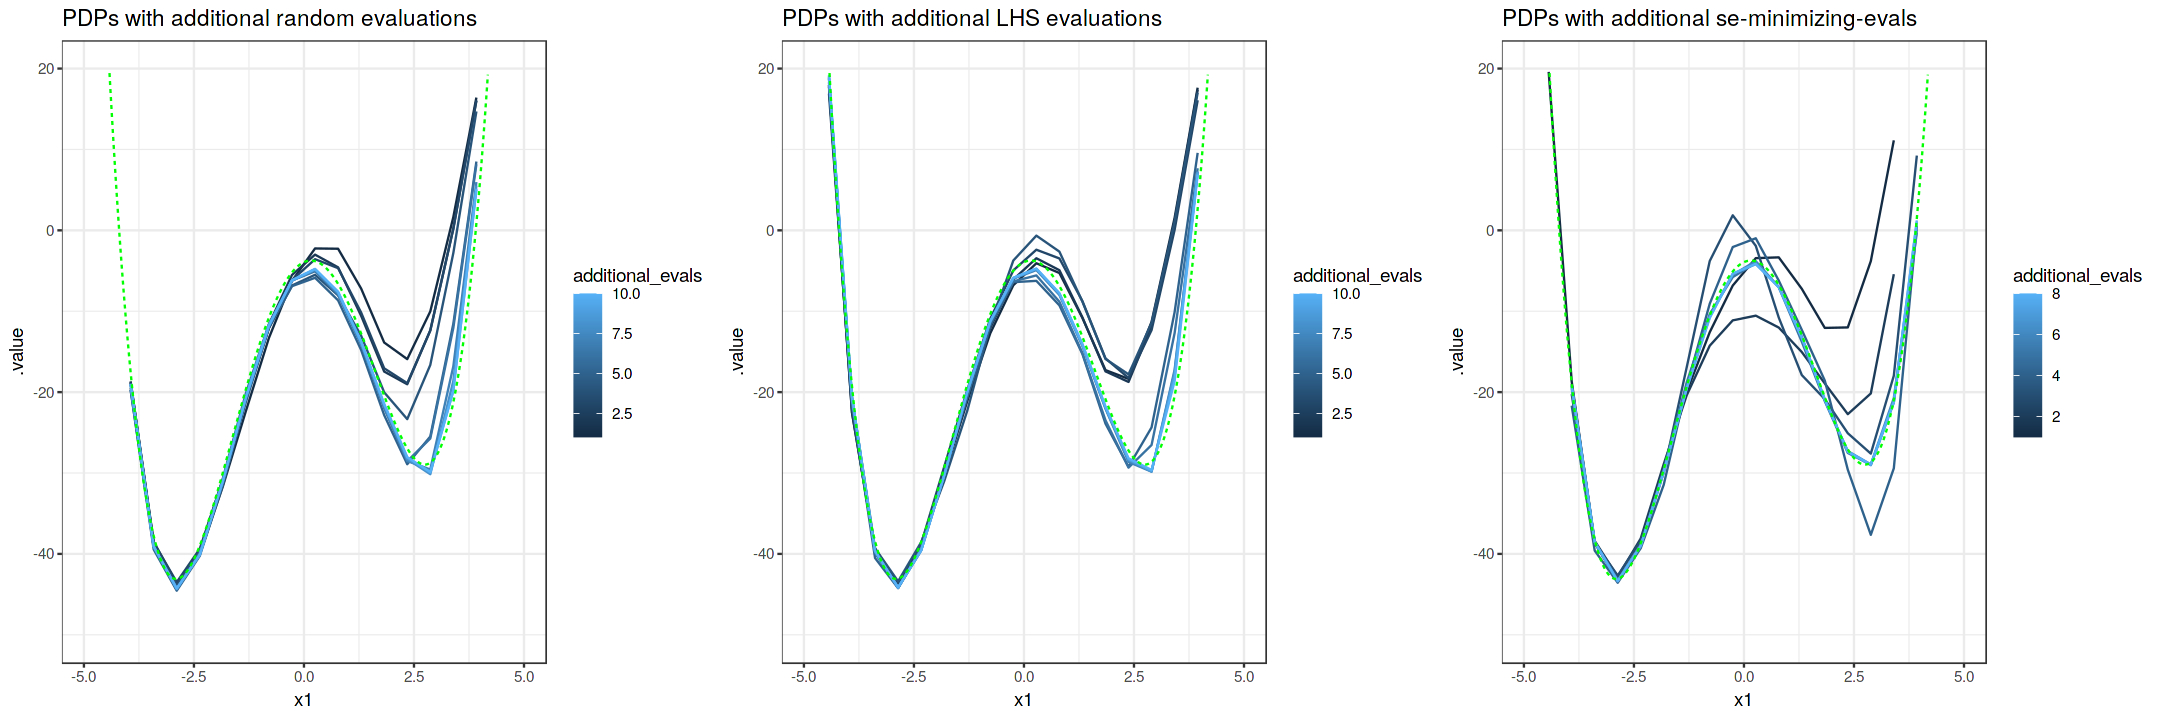

In [221]:
options(repr.plot.width = 18, repr.plot.height = 6)

grid.arrange(p1, p2, p3, ncol = 3)

## 3 -- Creating a "realistic" test sample

Usually, we evaluate the models on data that is generated by - for example - a random LHS. This does not correspond to the data distribution the model was trained on. 

We create a more realistic sample by: 
* Considering the infill criterion as "distribution" in every iteration
* Sampling n points from the infill criterion via rejection sampling 

In [262]:
run_1 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang_1.rds")

In [278]:
create_realistic_test_sample = function(run, points_per_iteration, iter, plot = TRUE) {
    
    ps = run$opt.path$par.set
    len = getParamLengths(ps)
    lower = getLower(ps)
    upper = getUpper(ps)
    
    # estimate the maximum and the minimum of the infill criterion 
    points = generateRandomDesign(n = 1000, par.set = ps)
    model = run_1$models[[iter]]
    p = predict(model, newdata = points)$data
    points = cbind(points, p)

    points$infill = points$response - run_1$control$infill.crit$params$cb.lambda * points$se

    # We want to draw a point if it has a low value with regards to the infill criterion - so we invert the infill criterion
    res = points$infill * (-1)

    # Sampling from envelope distribution
    vol = prod(unlist(lapply(ps$pars, function(x) prod(x$upper - x$lower))))

    rg = function(n) {
        sample = lapply(seq_len(n), function(x) sapply(seq_len(len), function(i) runif(1, min = lower[i], max = upper[i])))
        unlist(sample)
    }
    dg = function(x) 1 / vol

    df = function(x) {
        x = matrix(x, ncol = 3)
        x = as.data.frame(x)
        names(x) = getParamIds(ps, TRUE, TRUE)
        p = predict(model, newdata = x)$data
        - p$response + run$control$infill.crit$params$cb.lambda * p$se + abs(min(res))
    }
                                                       
    
    M = (max(res) + abs(min(res))) / ( 1 / vol)
    
    sim_vals = rejectionSampling(points_per_iteration, df = df, dg, rg, M = M, vectorized = TRUE)
    
    p = NULL
    
    if (plot) {
        p = ggplot() + geom_histogram(data = data.frame(x = sim_vals), aes(x = x, y = ..density..), binwidth = 0.05)

        # This object will expose the ingredients for the plot.
        ggp_build <- ggplot_build(p)

        # As for the tallest bin height:
        dens_max = max(ggp_build[["data"]][[1]][["density"]])

        points$normed = (res - min(res)) / (max(res) - min(res))
        points$normed = points$normed * dens_max

        p = p + geom_line(data = points, aes(x = x, y = (-1) * normed + max(normed)), colour = "red")
        p = p + geom_line(data = points, aes(x = x, y = normed), colour = "green")
    }
    
    return(list(values = sim_vals, plot = p))
}

In [279]:
create_realistic_test_sample(run_1, points_per_iteration = 10, iter = 1, plot = FALSE)

3.9432538,2.8228953,-3.11032198
4.9354773,-3.3747792,4.41315963
-3.9540930,0.8720254,1.37415037
2.9926260,3.4839160,-1.01788708
2.7814953,-4.1984965,-0.05705886
3.1614350,-2.7343534,2.76264524
-3.5469282,-3.5394665,-0.26571109
-0.9621701,-4.0750801,4.54018310
-3.9458545,0.5372672,-0.19040641
0.0000000,0.0000000,0.00000000


In [288]:
real_sample = lapply(seq_along(run_1$models), function(x) create_realistic_test_sample(run_1, 1000, iter = x, plot = FALSE)$values)

In [289]:
real_sample = do.call(rbind, real_sample)

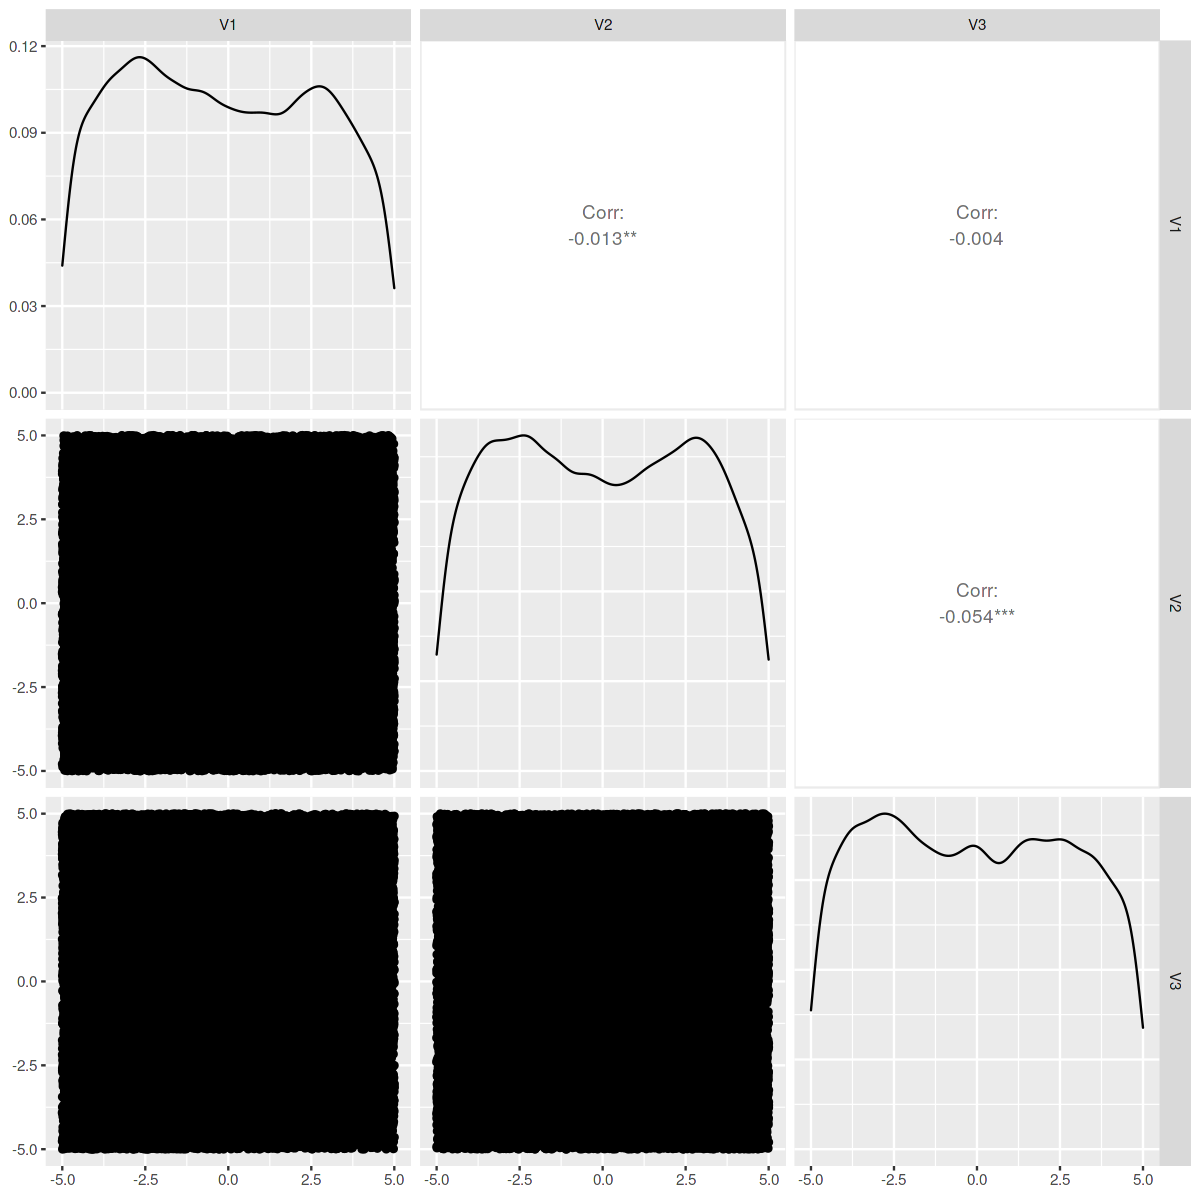

In [290]:
ggpairs(as.data.frame(real_sample))

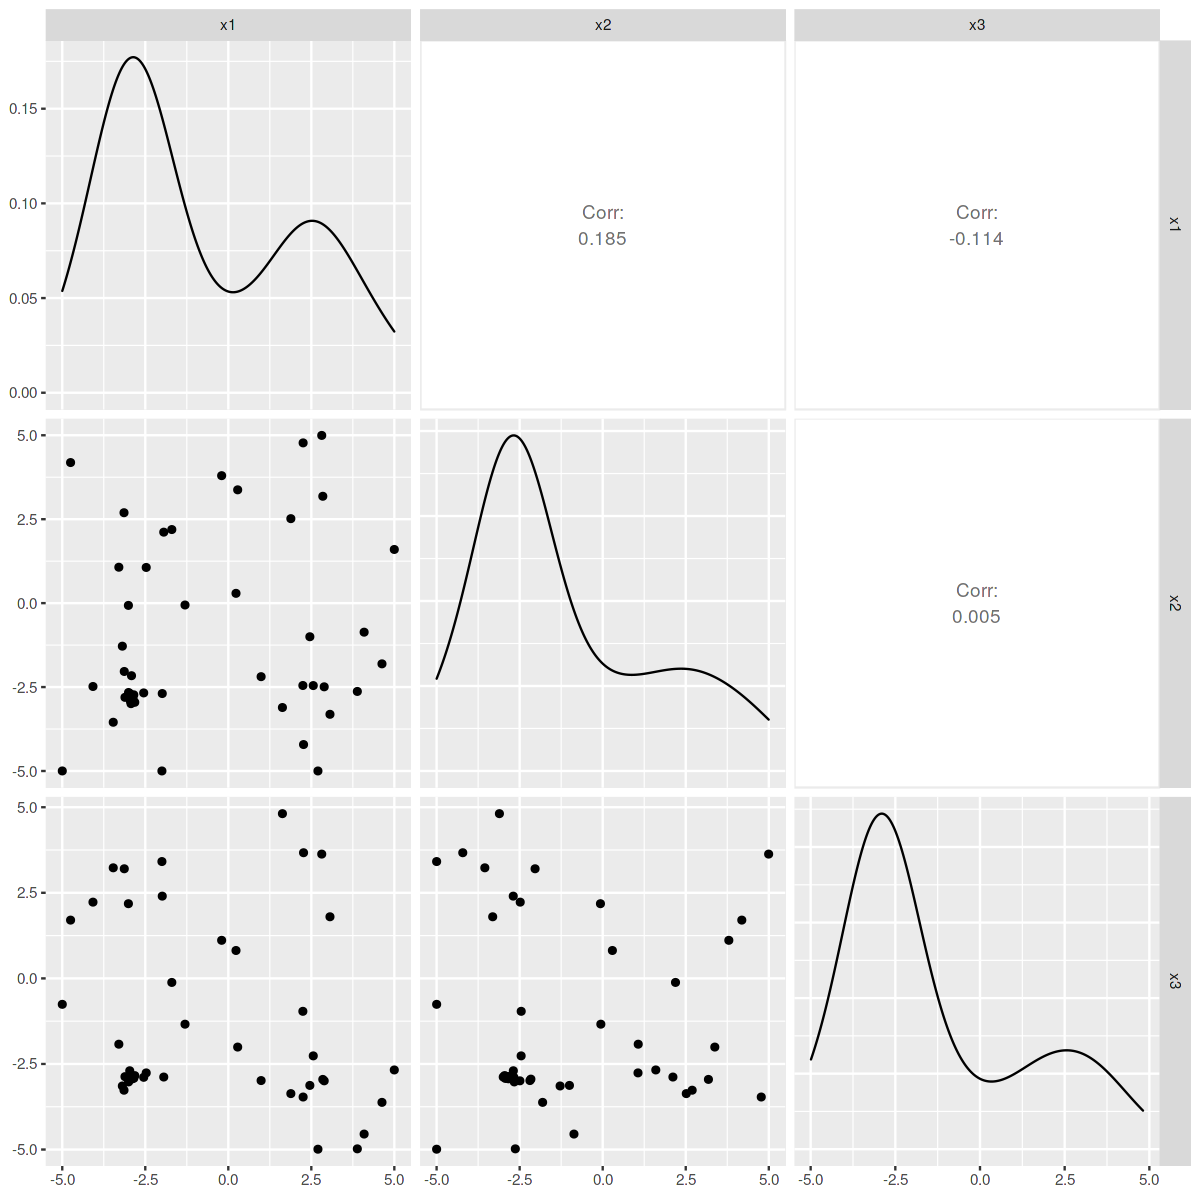

In [287]:
ggpairs(opdf)

In [213]:
points = generateRandomDesign(n = 1000, par.set = ps)

model = run_1$models[[1]]
p = predict(model, newdata = points)$data
res = p$response - run_1$control$infill.crit$params$cb.lambda * p$se

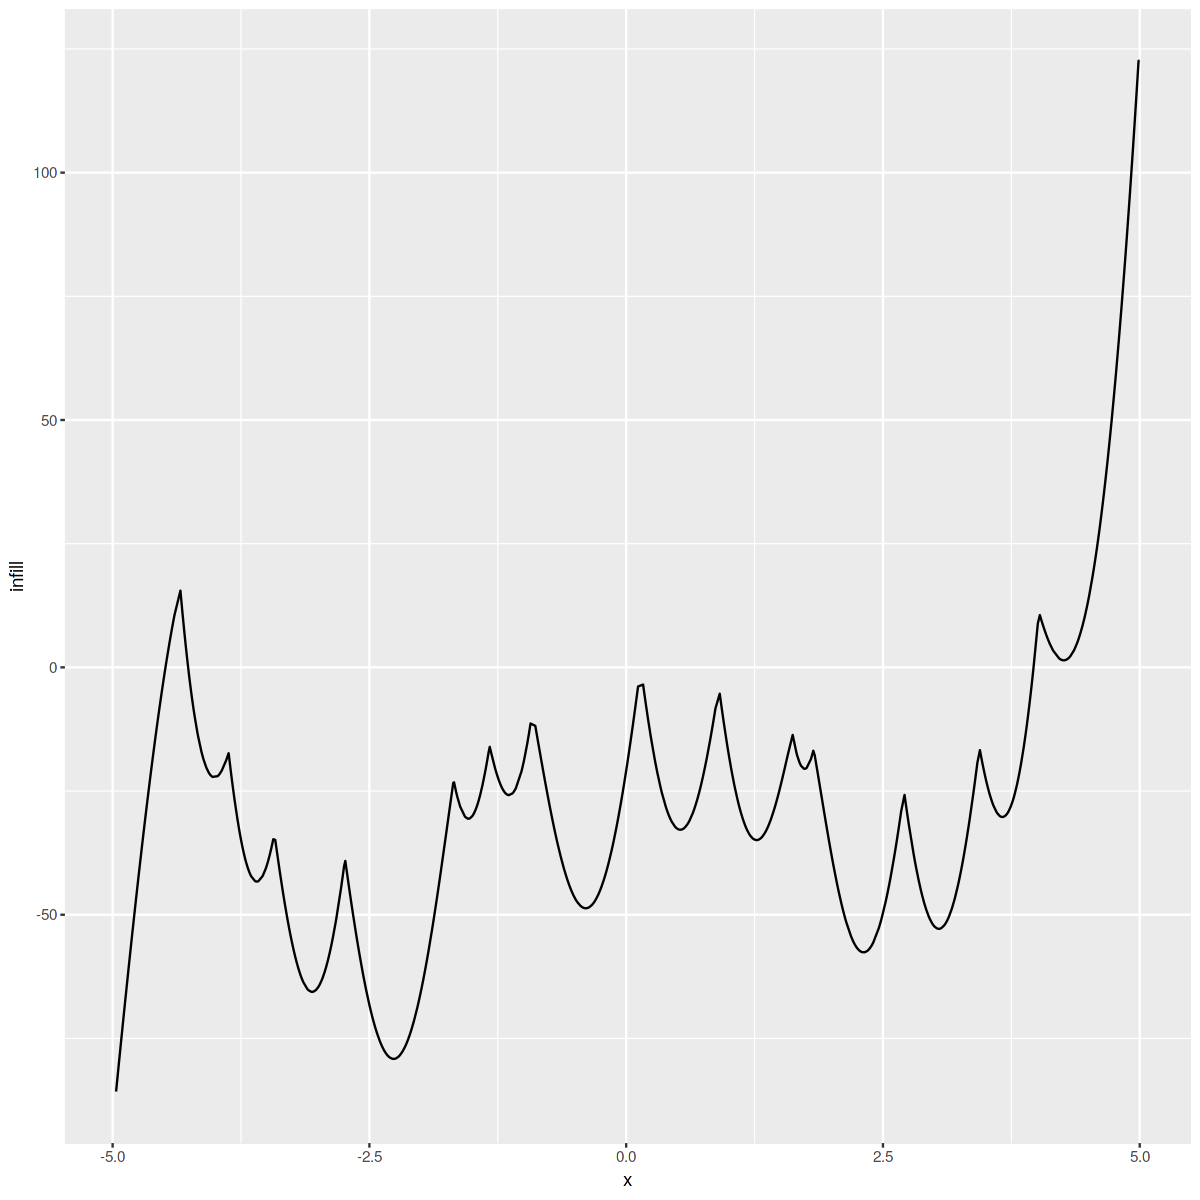

In [214]:
p = ggplot(data = data.frame(x = points$x, infill = res)) 
p = p + geom_line(aes(x = x, y = infill))
p

In [219]:
# scale the infill criterion accordingly

summary(res2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05973 0.08700 0.08935 0.10600 0.32800 

In [221]:
data.frame(x = points$x, y = res2)

x,y
<dbl>,<dbl>
-0.12378470,0.07940564
0.93101084,0.12178365
1.87595822,0.09909295
-3.19298946,0.03933901
2.63709024,0.08033404
-4.28316402,0.14030105
-1.32823359,0.10968510
3.44830468,0.10788027
3.77583093,0.09382233


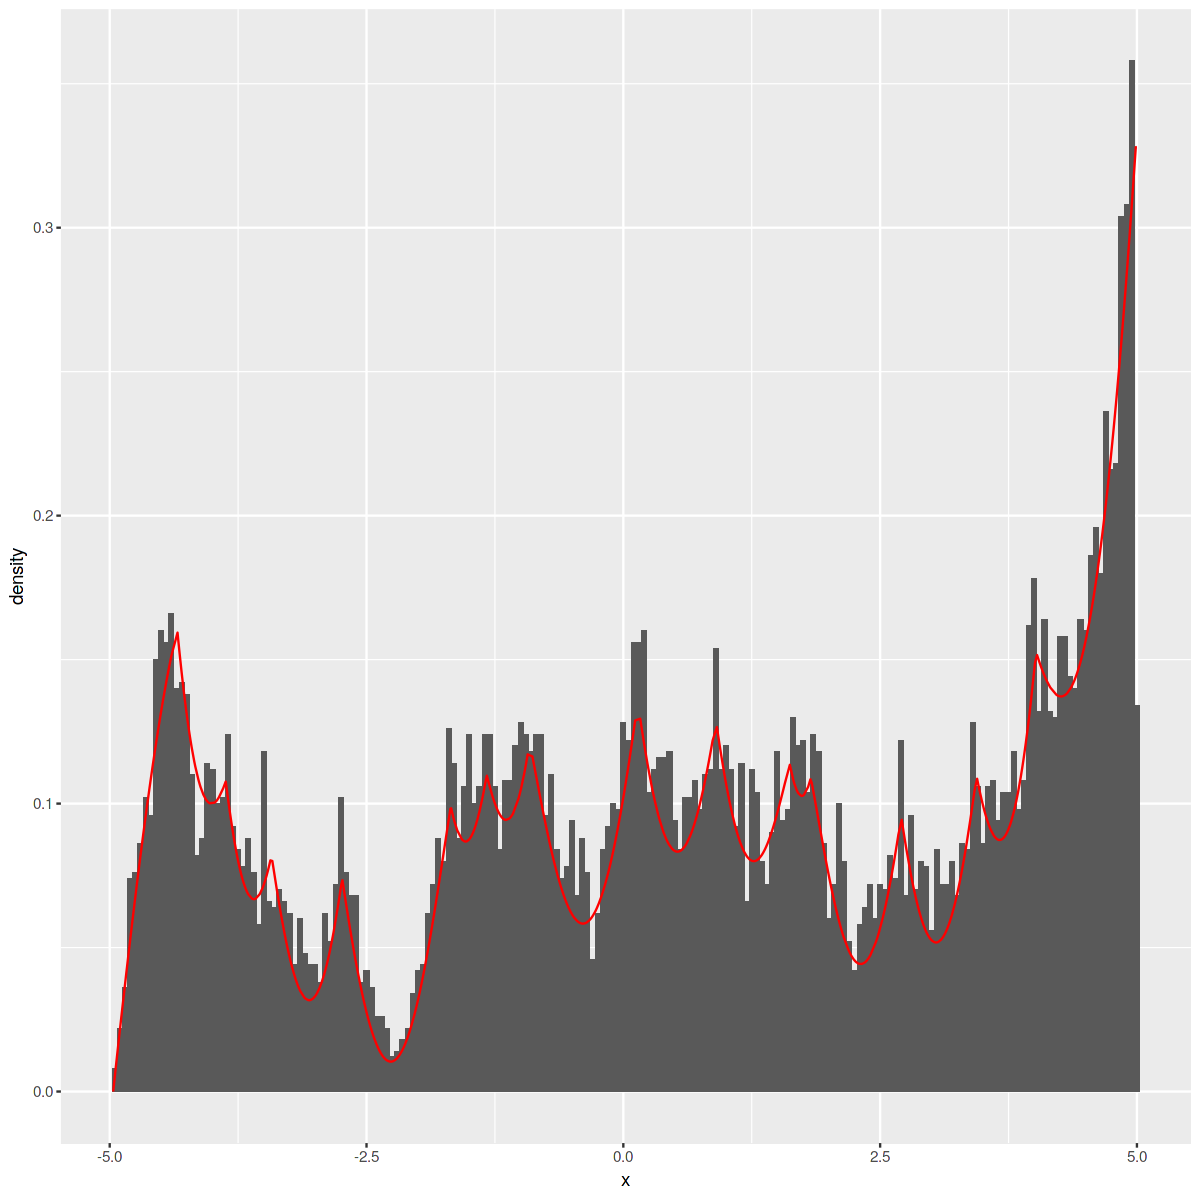

In [228]:
p + geom_line(data = data.frame(x = points$x, y = res2), aes(x = x, y = y), colour = "red")

## 3 -- Visualization of Runs

In [292]:
run_1 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang_1.rds")
run_10 = readRDS("synthetic/mlrmbo_run_StyblinkskiTang_10.rds")

In [293]:
opdf_1 = as.data.table(as.data.frame(run_1$opt.path))
opdf_1$lambda = 1
opdf_10 = as.data.table(as.data.frame(run_10$opt.path))
opdf_10$lambda = 10

opdf = rbind(opdf_1, opdf_10)

opdf_m = reshape2::melt(opdf, id.vars = c("x1", "x2", "x3", "lambda"), measure.vars = "prop.type")

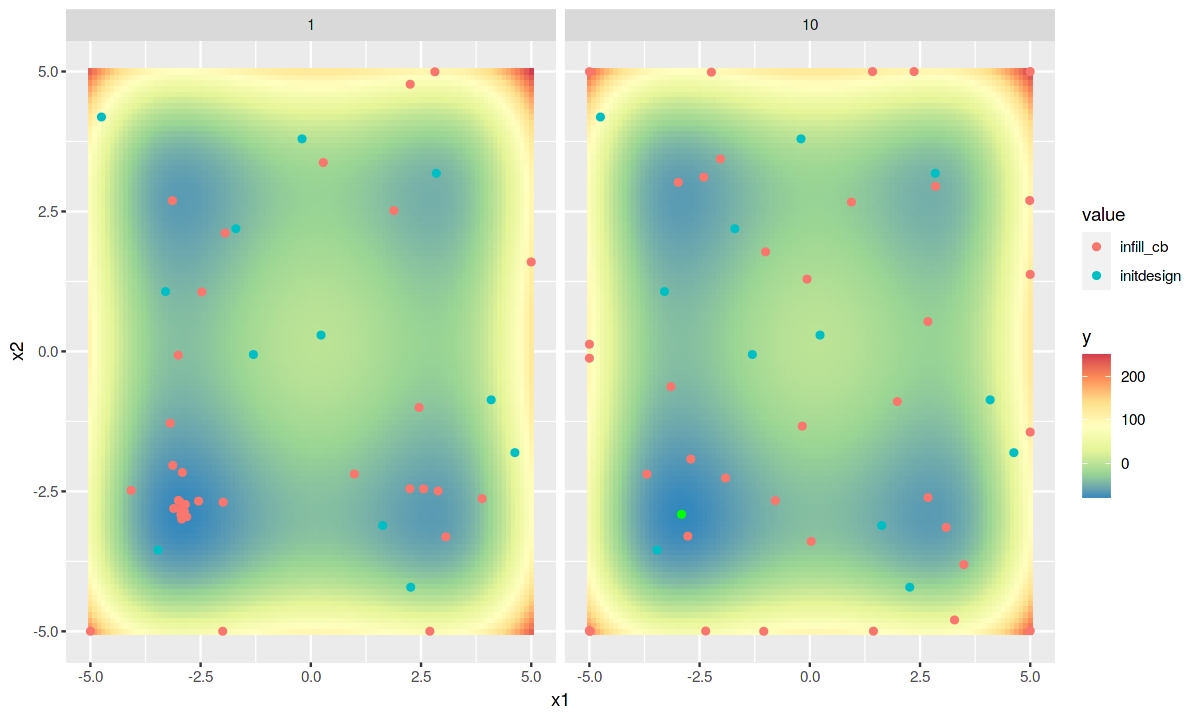

In [294]:
options(repr.plot.width=10, repr.plot.height=6)

p2 = p + geom_point(data = opdf_m, aes(x = x1, y = x2, colour = value))
p2 + facet_wrap(lambda ~ .)

## 4-- Quality of the Surrogate Models 

In [302]:
# We create a huge design 
x1 = seq(-5, 5, length.out = 50)

gg <- expand.grid(x1 = x1, x2 = x1, x3 = x1)

In [303]:
model_1 = run_1$models
model_1 = model_1[[length(model_1)]]

model_10 = run_10$models
model_10 = model_10[[length(model_10)]]

In [304]:
run_1_pred = predict(model_1, newdata = gg)
run_10_pred = predict(model_10, newdata = gg)

gg$y = apply(gg[, c("x1", "x2", "x3")], 1, obj)

gg$run_1_err = sqrt((run_1_pred$data$response - gg$y)^2)
gg$run_10_err = sqrt((run_10_pred$data$response - gg$y)^2)

In [310]:
gg_m = reshape2::melt(data = gg, id.vars = c("x1", "x3"), measure.vars = c("run_1_err", "run_10_err"))

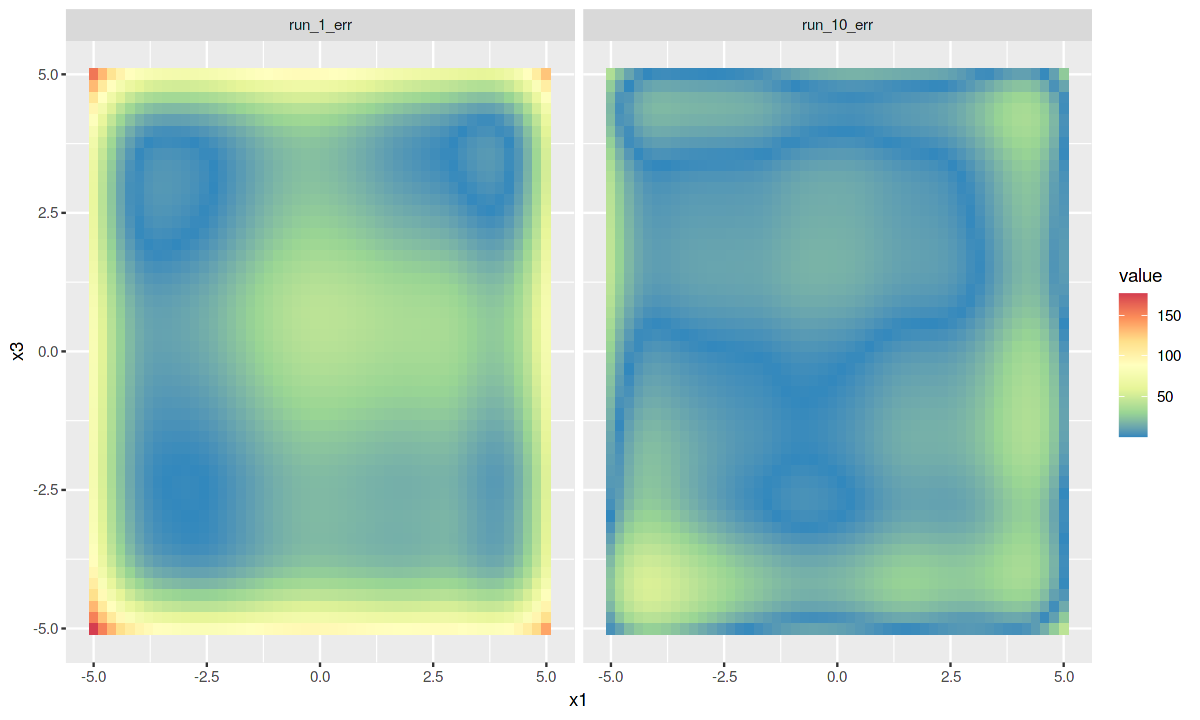

In [312]:
p = ggplot(data = gg_m, aes(x = x1, y = x3, fill = value)) + geom_tile()
p = p + scale_fill_distiller(palette = "Spectral")
p + facet_grid(. ~ variable)

## 5 -- Investigate PDP's

In [277]:
# How the PDP's ideally should look like 
# The function is symmetric
obj_marg_2D = function(x) 5 * x^4 - 80 * x^2 + 25 * x - 125 / 3
obj_marg_3D = function(x) 50 * x^4 - 800 * x^2 - 250 * x - 2500 / 3

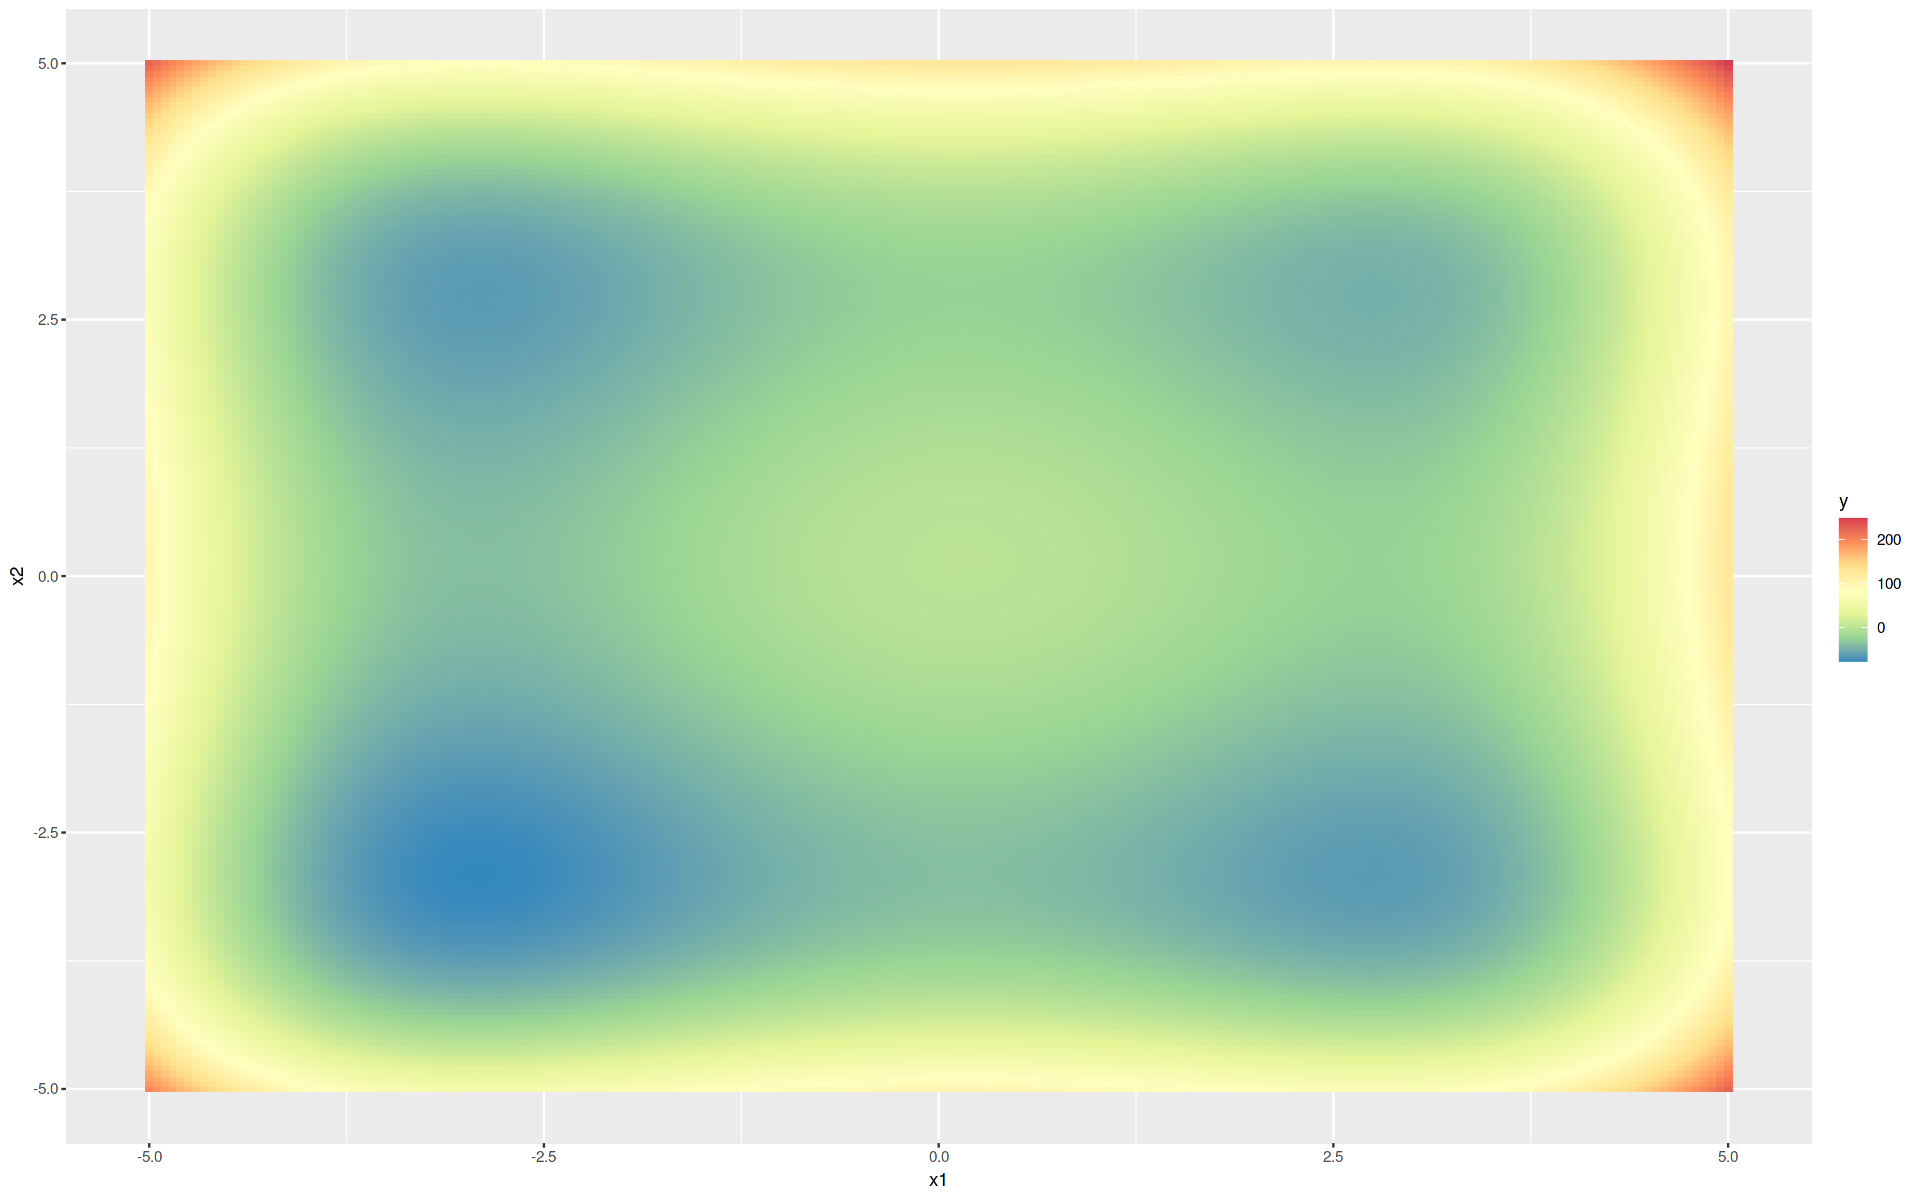

In [254]:
p = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p = p + scale_fill_distiller(palette = "Spectral")
p = p + geom_point(x = opt$param$x1, y = opt$param$x2, colour = "green")
p 

In [255]:
p1 =ggplot(data = data.frame(x = 0), mapping = aes(x = x))
p1 = p1 + stat_function(fun = obj_marg_x) + xlim(-5,5)

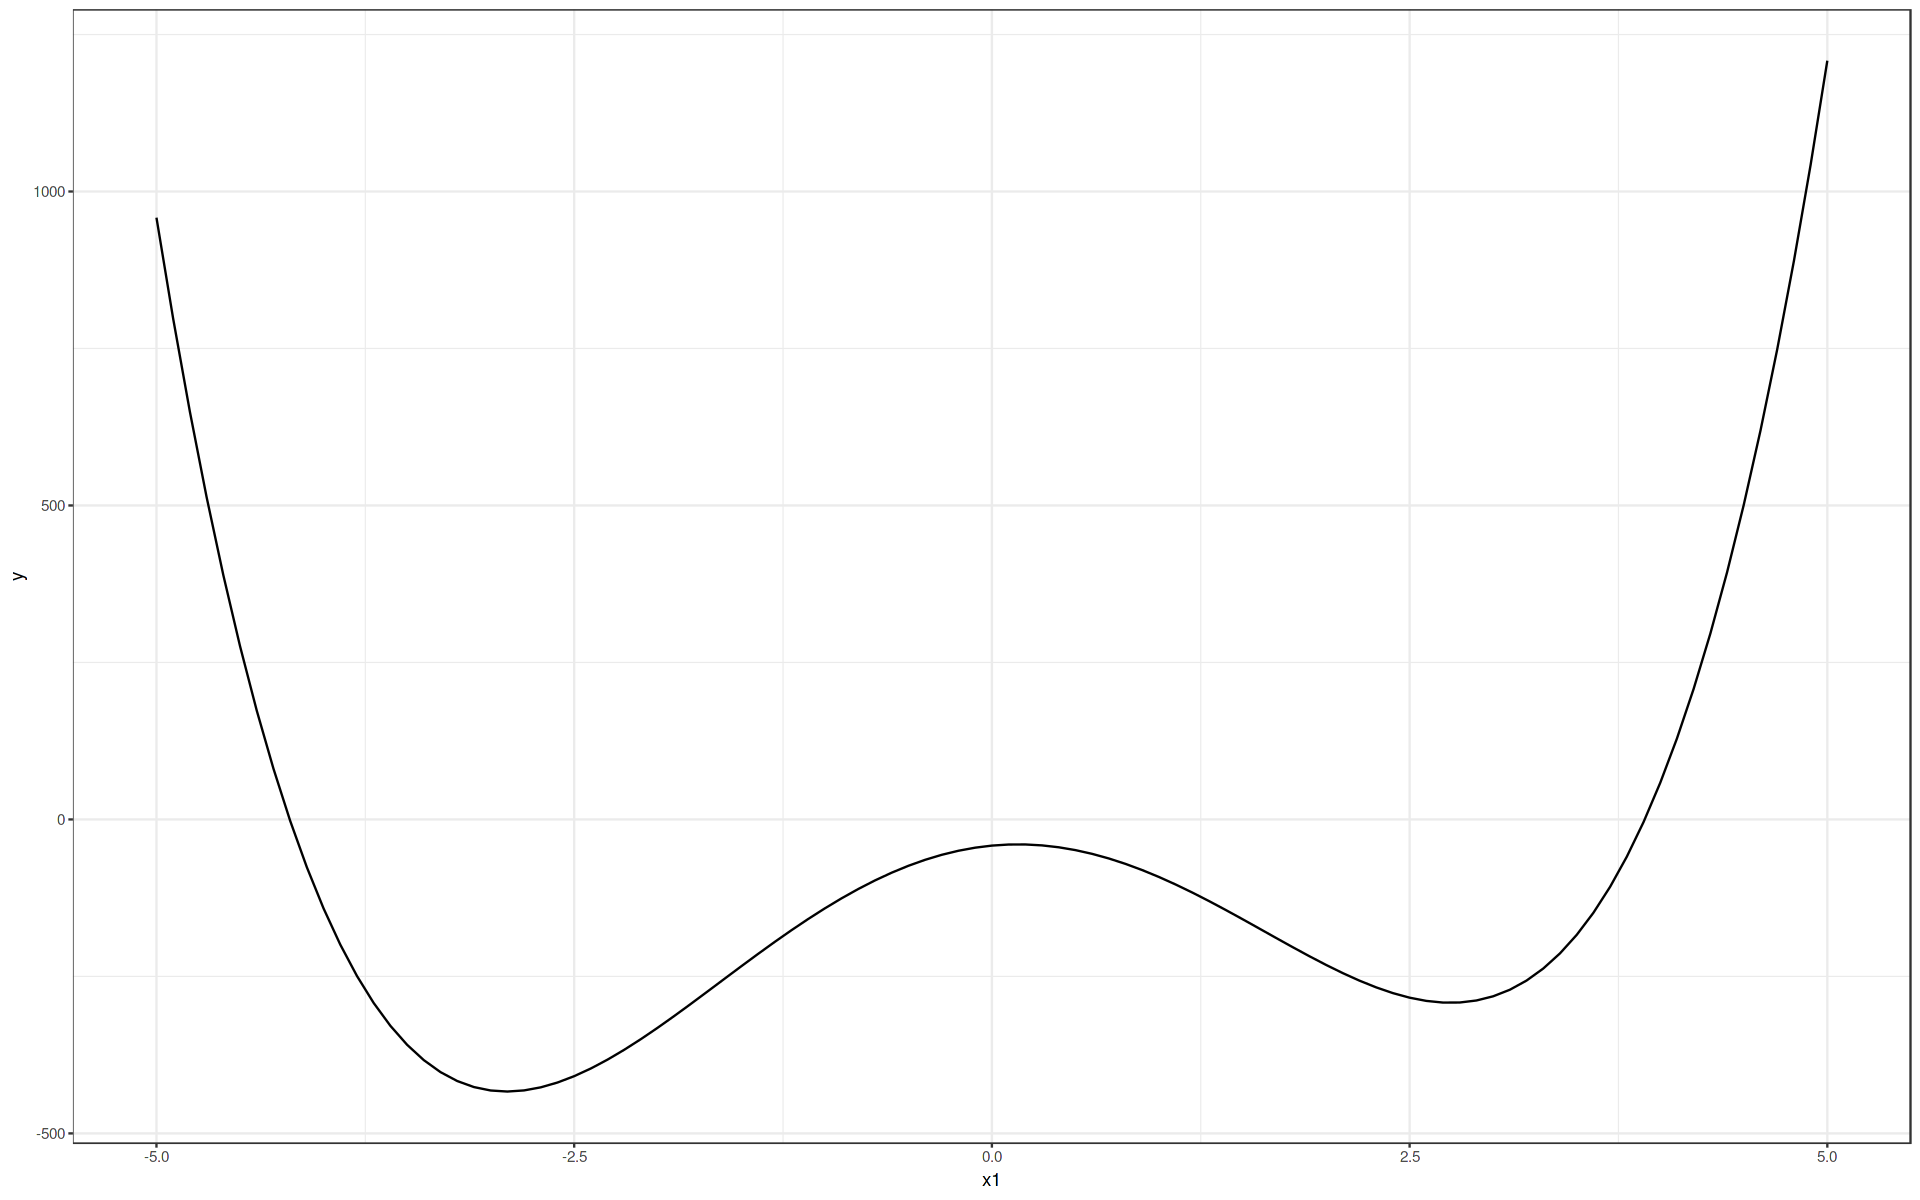

In [216]:
p1 + theme_bw() + xlab("x1")

In [266]:
pred = Predictor$new(model = model_1, data = opdf_1[, c("x1", "x2", "lambda", "y"), ], y = "y")

ERROR: Error in .subset2(public_bind_env, "initialize")(...): Only 1 feature was provided. The iml package is only useful and works for multiple features.
